#Presentación

Este trabajo se centra en el ciclo de vida del machine learning. En este caso el objetivo es realizar modelos y ponerlos en producción para predecir si va a llover y cuanto va a llover mañana (en algunas localidades de Australia). Para ello se hace un análisis de los datos, se prueban distintos modelos, se optimizan mediante distintas técnicas y se comparan con las métricas pertinentes para luego ser puestos en produccion con streamlit

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.4 MB/s eta 0:00:00


In [2]:
!pip install tensorflow
!pip install keras

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#Análisis Descriptivo

En esta sección del código identifico la cantidad de valores faltantes. Tomo la decisión de eliminar todos los NaNs de las variables target ya que cualquier forma de llenarlas solo introduciría ruido (nuestro objetivo es poder predecir esas variables).

Luego veo las medias y desvios de cada variable, y hago un plot para identificar cuales son las variables que mejor parecen explicar si llueve mañana o no (humidity 3 pm y sunshine principalmente). Analizo con histogramas la distribución de las variables, donde como es esperable la mayoría tienen una distribución normal.
Hago una matriz de correlacion lineal y un top de variables con mayor correlacion tanto positiva como negativa, y se consiguen algunos resultados obvios, como que la temperatura a cierta hora esta muy correlacionada con la temperatura maxima y minima. Aún así no elimino estas variables porque podrían contener información, para eliminarlas es necesario un estudio mucho más exhaustivo.

Los datos faltantes son mayormente tratados mediante la imputacion por el valor de la ciudad mas cercana disponible, luego de ello el dataset queda casi completamente limpio.

Las variables de fecha y de direcciones del viento se proyectan en un plano cartesiano y se crean "dummies" de solo dos variables, de esta forma las direcciones de viento cercanas y los meses cercanos estarán cerca en esta proyeccion.

Se divide en conjunto de train y test con shuffle=False ya que es una serie temporal y los datos de test tienen que ser todos del "futuro" respecto de los de train. Luego de eso se realiza un escalado por z-score y una imputacion por la media y la moda, esto se realiza de forma coherente para no tener fuga de datos.

En esta etapa se guarda una version del dataset para luego usarlo en MLOPS.

Se detecta que el dataset está fuertemente desbalanceado por lo que será necesario balancearlo a la hora de hacer clasificacion, y tambien se tendran que usar metricas pertinentes como el f1 score.

In [8]:
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',')
ciudades = ['Albury', 'Sydney', 'SydneyAirport', 'Canberra','MelbourneAirport', 'Melbourne']
df2 = df[df['Location'].isin(ciudades)]
df2.drop(columns=['Unnamed: 0'],inplace=True)

#Abro el dataframe, elimino los datos de ciudades que no se van a analizar y la columna Unnamed

<ipython-input-8-5c0ac58d4a46>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(columns=['Unnamed: 0'],inplace=True)


In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19025 entries, 0 to 70370
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              19025 non-null  object 
 1   Location          19025 non-null  object 
 2   MinTemp           18523 non-null  float64
 3   MaxTemp           18528 non-null  float64
 4   Rainfall          18209 non-null  float64
 5   Evaporation       14280 non-null  float64
 6   Sunshine          14038 non-null  float64
 7   WindGustDir       17536 non-null  object 
 8   WindGustSpeed     17538 non-null  float64
 9   WindDir9am        17805 non-null  object 
 10  WindDir3pm        18690 non-null  object 
 11  WindSpeed9am      18755 non-null  float64
 12  WindSpeed3pm      18765 non-null  float64
 13  Humidity9am       18446 non-null  float64
 14  Humidity3pm       18492 non-null  float64
 15  Pressure9am       18285 non-null  float64
 16  Pressure3pm       18291 non-null  float6

In [10]:
df2.isna().sum()
#analisis de cantidad de valores faltantes

Date                   0
Location               0
MinTemp              502
MaxTemp              497
Rainfall             816
Evaporation         4745
Sunshine            4987
WindGustDir         1489
WindGustSpeed       1487
WindDir9am          1220
WindDir3pm           335
WindSpeed9am         270
WindSpeed3pm         260
Humidity9am          579
Humidity3pm          533
Pressure9am          740
Pressure3pm          734
Cloud9am            4428
Cloud3pm            4545
Temp9am              514
Temp3pm              504
RainToday            816
RainTomorrow         816
RainfallTomorrow     816
dtype: int64

In [11]:
df2.dropna(subset=['Rainfall', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'], inplace=True)

<ipython-input-11-1e7081636e82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(subset=['Rainfall', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'], inplace=True)


In [12]:
df2.describe()
#Valores estadísticos de las variables, como las medias son muy distintas va a ser obligatorio estandarizar

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,18017.000000,18020.000000,18026.000000,13355.000000,13105.000000,16584.000000,17765.000000,17770.000000,17936.000000,17979.000000,17774.000000,17778.000000,14410.000000,14303.000000,18000.000000,18008.000000,18026.000000
mean,11.264728,21.941160,2.237690,4.881041,6.907707,42.252894,15.060118,20.497636,69.746041,50.679737,1018.342011,1016.022151,4.885496,4.802978,15.383039,20.458374,2.192433
std,5.966638,6.388263,7.227048,3.056038,3.837245,15.310533,10.235984,9.579493,16.083328,18.160965,7.395542,7.242085,2.742710,2.625254,5.732940,6.183585,7.143983
min,-8.000000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,11.000000,3.000000,986.700000,982.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,7.400000,17.000000,0.000000,2.600000,3.800000,31.000000,7.000000,13.000000,59.000000,38.000000,1013.400000,1011.100000,2.000000,2.000000,11.200000,15.800000,0.000000
50%,11.300000,21.400000,0.000000,4.200000,7.600000,41.000000,13.000000,20.000000,70.000000,50.000000,1018.500000,1016.150000,6.000000,6.000000,15.300000,19.900000,0.000000
75%,15.600000,26.200000,0.800000,6.600000,10.000000,52.000000,20.000000,26.000000,81.000000,62.000000,1023.300000,1020.900000,7.000000,7.000000,19.500000,24.600000,0.600000
max,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,119.400000


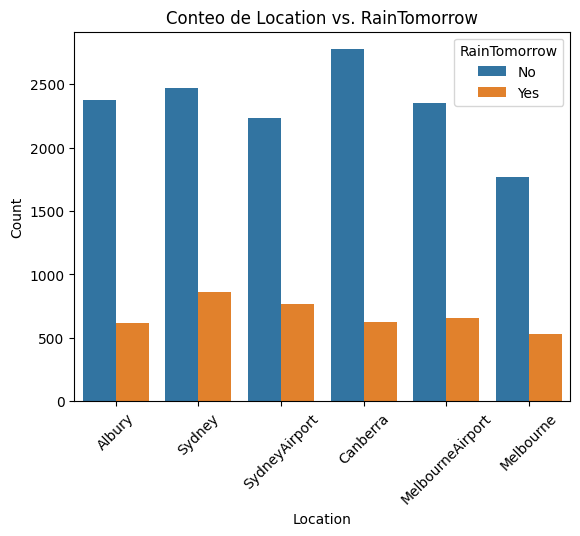

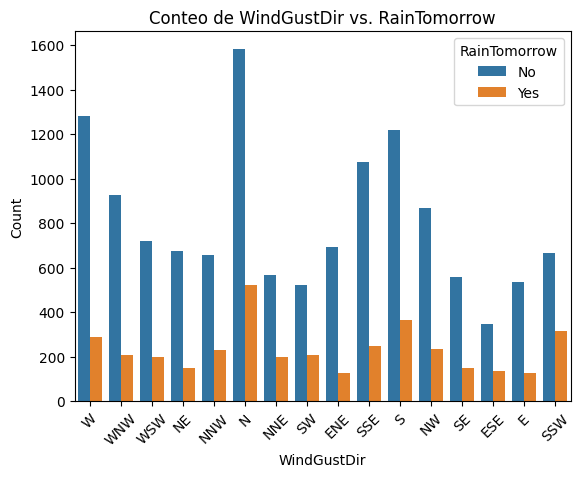

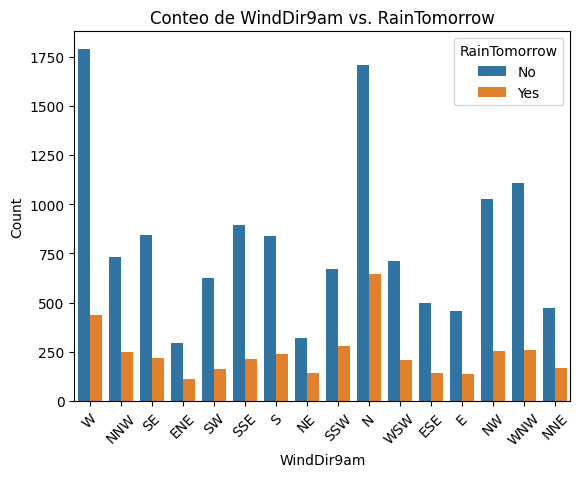

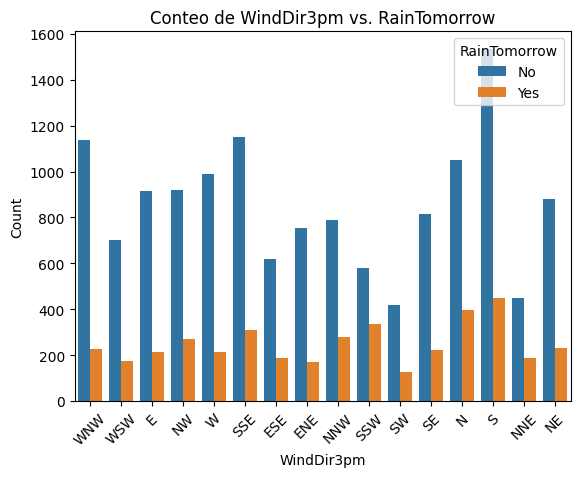

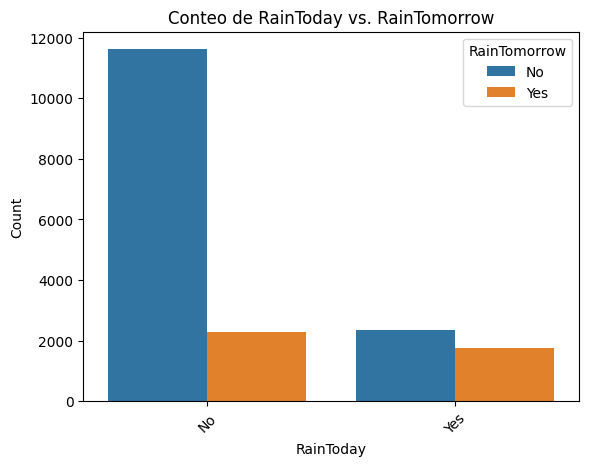

In [13]:
for column in df2.select_dtypes(include='object').columns:
    if column != 'RainTomorrow' and column != 'Date':
        sns.countplot(x=column, hue='RainTomorrow', data=df2)
        plt.title(f'Conteo de {column} vs. RainTomorrow')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='RainTomorrow', loc='upper right')
        plt.show()

#Una idea inicialmente era elegir solo la primer componente del viento, pero se puede apreciar
#Que distintos vientos con la misma primer componente son muy distintos

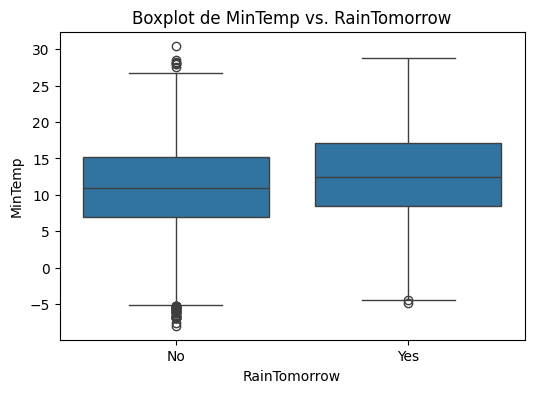

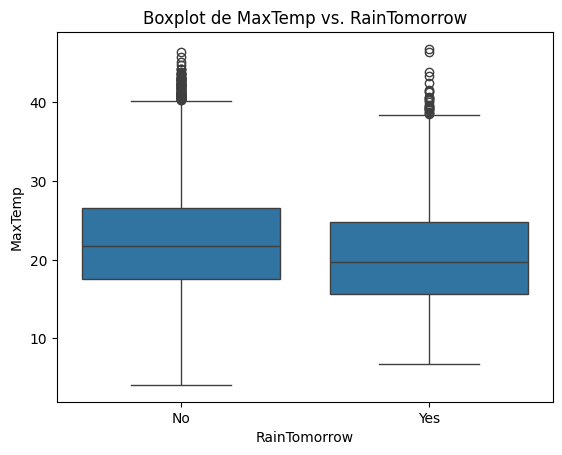

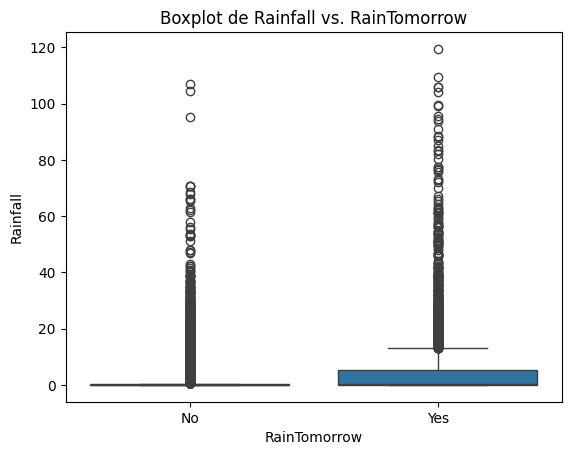

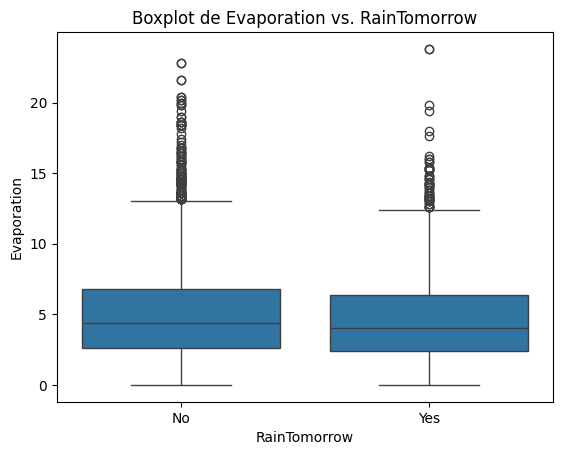

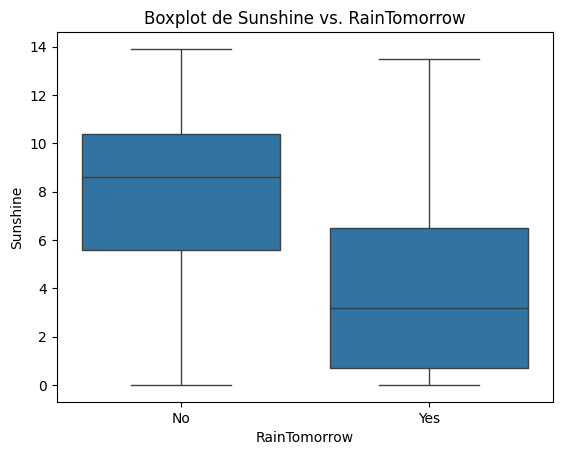

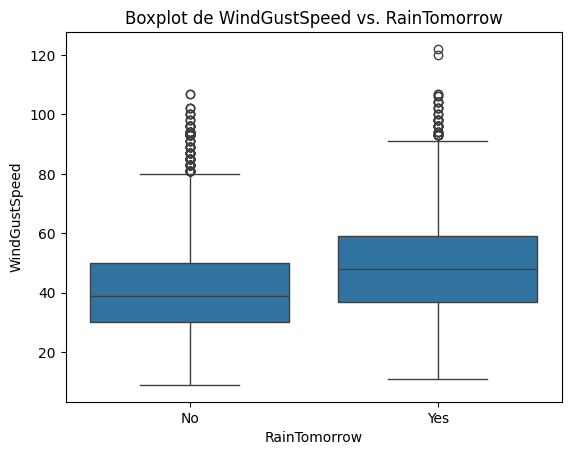

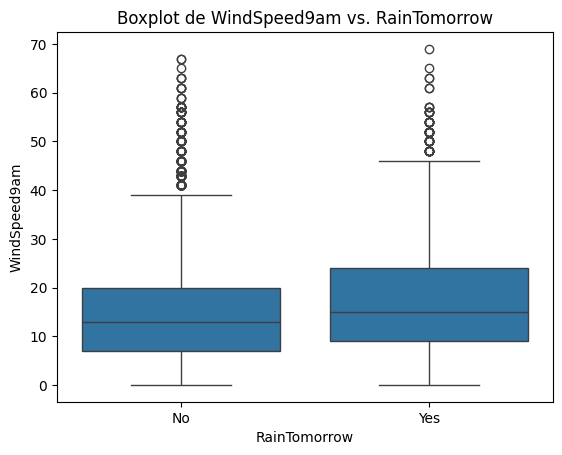

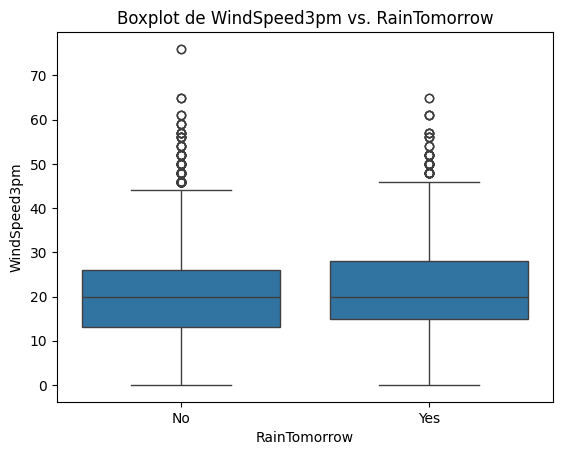

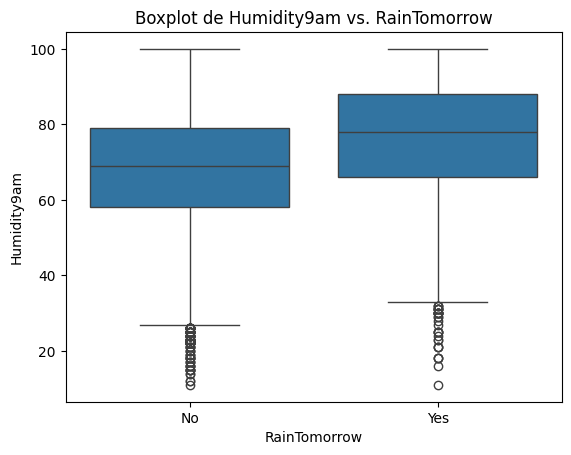

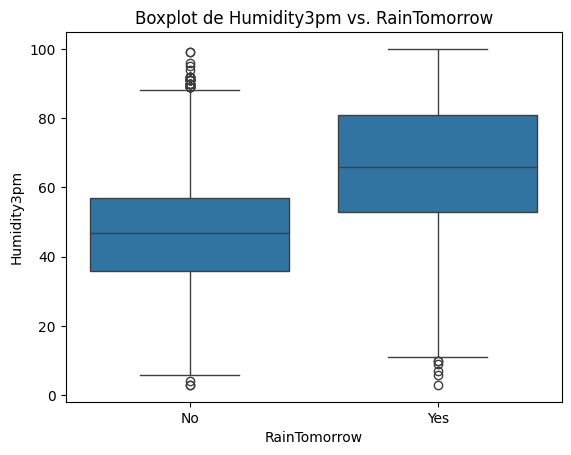

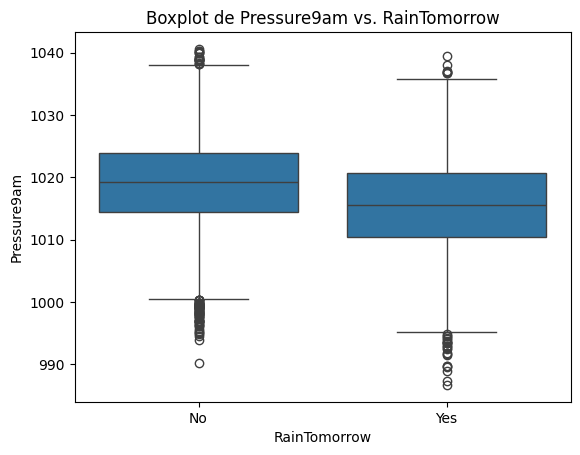

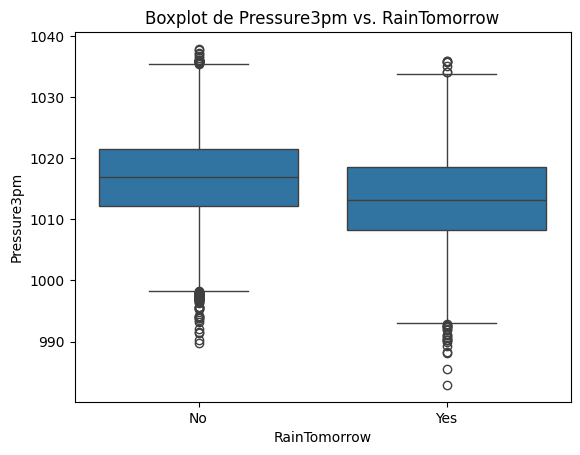

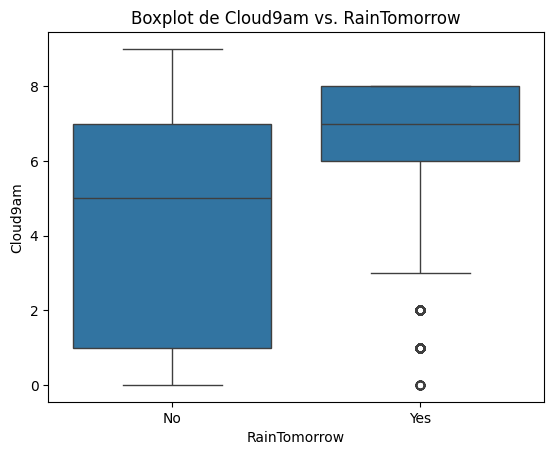

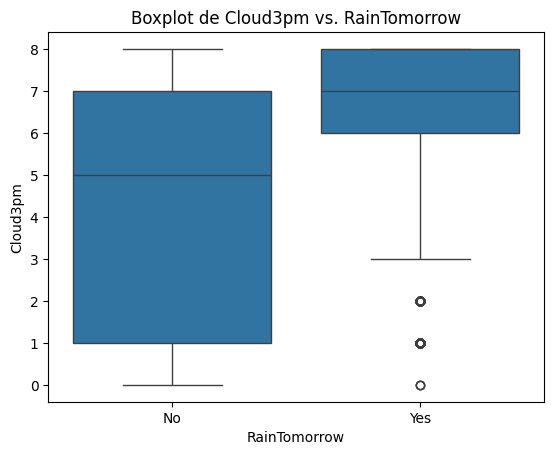

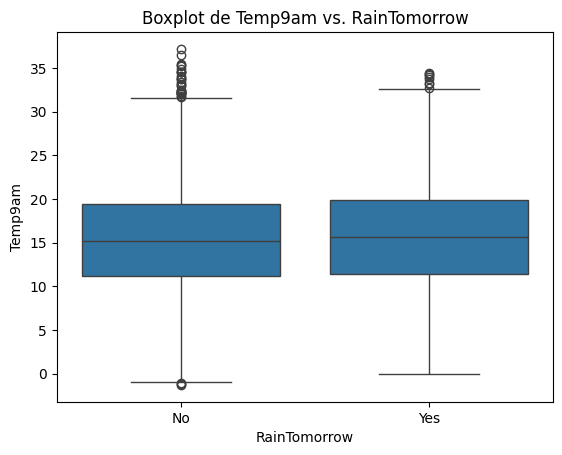

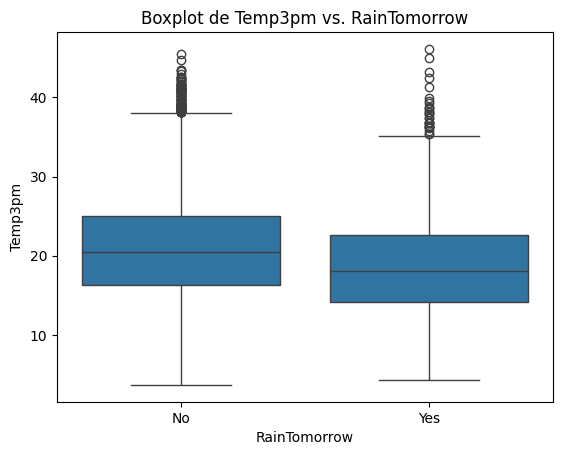

In [14]:
plt.figure(figsize=(6, 4))

for column in df2.describe().columns[0:]:
    if column != 'RainTomorrow' and column != 'RainfallTomorrow':
        sns.boxplot(x='RainTomorrow', y=column, data=df2)
        plt.title(f'Boxplot de {column} vs. RainTomorrow')
        plt.ylabel(column)
        plt.show()
#Analisis superficial para detectar las variables que puedan ser más explicativas de RainTomorrow
#RainfallTomorrow es excluida por tener una correlación obvia

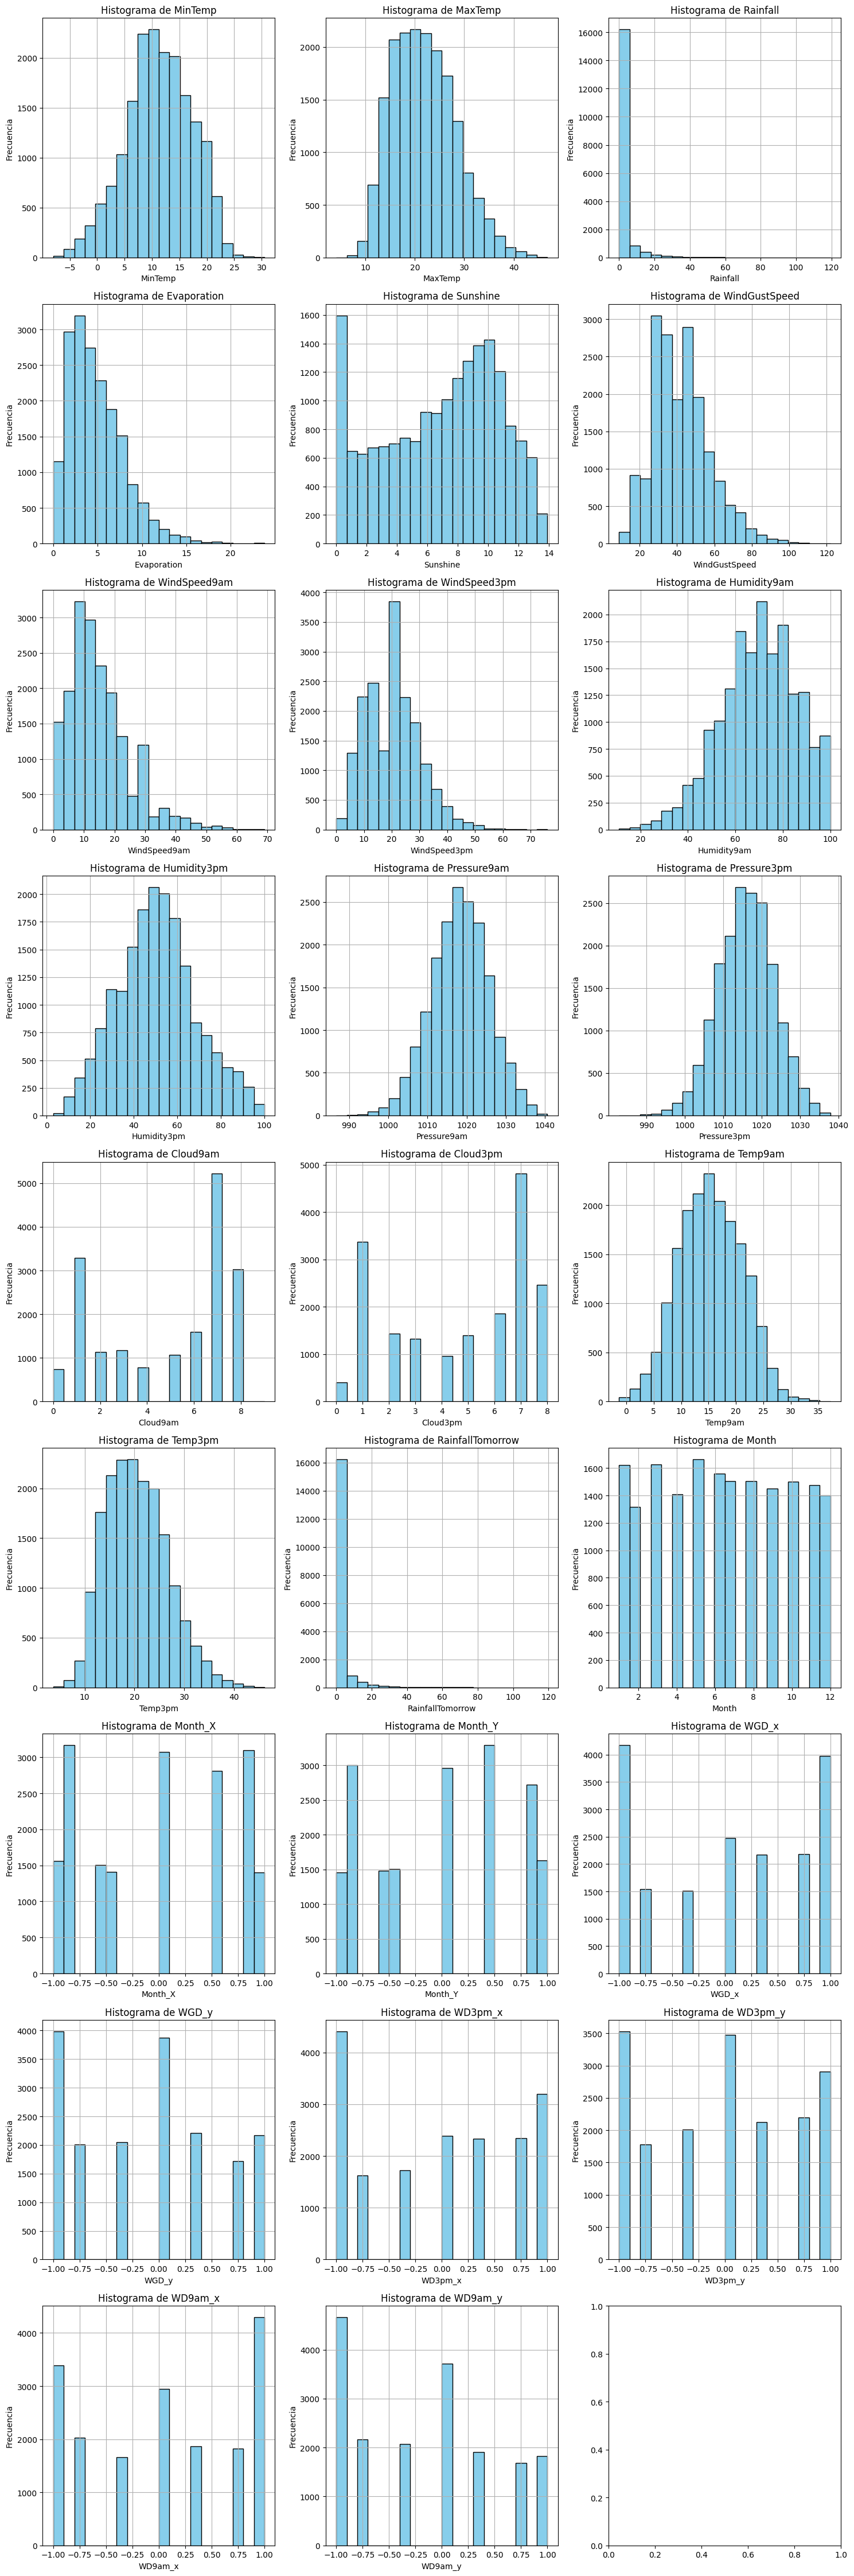

In [67]:
#Selecciono las variables númericas
numeric_cols = df2.select_dtypes(include=['float64', 'int64'])

num_cols = len(numeric_cols.columns)
num_rows = int(np.ceil(num_cols / 3))

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

for i, column in enumerate(numeric_cols.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ax.hist(df2[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histograma de {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')
    ax.grid(True)


plt.tight_layout()
plt.show()

#Se observa que la mayoría de variables son normales
#El comportamiento bimodal de sunshine es lógico, los días que el cielo está completamente nublado son más comunes que los puntos medios
#Las relacionadas a rainfall estan sesgadas a la derecha porque la mayoría de días no llueve


<ipython-input-15-d6674dce02d2>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df2.corr().select_dtypes(include=[np.number]).round(2), annot=True)


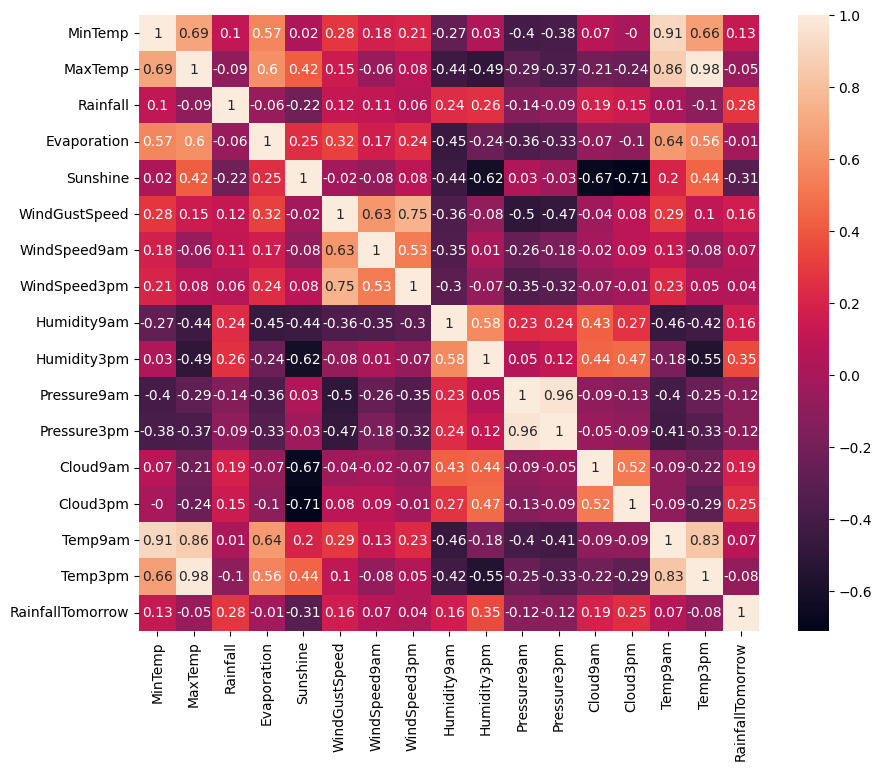

In [15]:
plt.figure(figsize=(10, 8))

sns.heatmap(df2.corr().select_dtypes(include=[np.number]).round(2), annot=True)

plt.show()

#Matriz de correlación entre variables cuantitativas, se ve que hay varias características con correlaciones lineales altas
#Algunas son obvias (mintemp/maxtemp, sunshine/clouds)
#Aún así no es recomendable eliminarlas manualmente por riesgo a perder informacion util

In [17]:
matrix_corr = df2.corr(method='pearson')

upper_matrix_corr = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(bool))

# Con estas matrices triangulares superiores
top_pos_corr = upper_matrix_corr.unstack().dropna().sort_values(ascending=False).head(25)
top_neg_corr = upper_matrix_corr.unstack().dropna().sort_values(ascending=True).head(20)

print("Top Correlaciones Positivas:\n")
print(top_pos_corr)
print("\n---------------------------------")
print("\nTop Correlaciones Negativas:\n")
print(top_neg_corr)

Top Correlaciones Positivas:

Temp3pm           MaxTemp          0.980293
Pressure3pm       Pressure9am      0.960925
Temp9am           MinTemp          0.909539
                  MaxTemp          0.857259
Temp3pm           Temp9am          0.825980
WindSpeed3pm      WindGustSpeed    0.746816
MaxTemp           MinTemp          0.691162
Temp3pm           MinTemp          0.662046
Temp9am           Evaporation      0.636143
WindSpeed9am      WindGustSpeed    0.634662
Evaporation       MaxTemp          0.600063
Humidity3pm       Humidity9am      0.584338
Evaporation       MinTemp          0.567949
Temp3pm           Evaporation      0.561921
WindSpeed3pm      WindSpeed9am     0.533583
Cloud3pm          Cloud9am         0.520018
                  Humidity3pm      0.471366
Cloud9am          Humidity3pm      0.442351
Temp3pm           Sunshine         0.441943
Cloud9am          Humidity9am      0.426261
Sunshine          MaxTemp          0.419505
RainfallTomorrow  Humidity3pm      0.354147
Wi

<ipython-input-17-e32171cc2f11>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_corr = df2.corr(method='pearson')


Text(0.5, 1.0, 'RainToday Distribution')

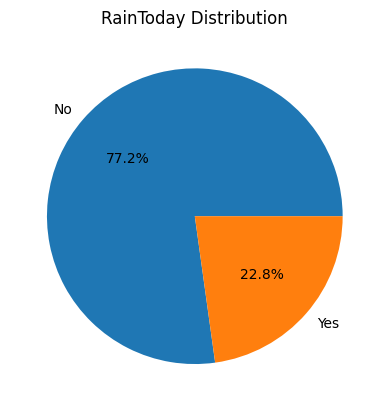

In [18]:
rain_today_counts = df2['RainToday'].value_counts()

plt.pie(rain_today_counts, labels=rain_today_counts.index, autopct='%1.1f%%')

plt.title('RainToday Distribution')

#Como el dataset está desbalanceado va a ser necesario utilizar métodos que eviten un sesgo a la clase mayoritaria
#También va a ser necesario usar métricas distintas de accuracy, como F1Score o recall (yo elegí F1Score)

In [19]:
from geopy.distance import geodesic
import itertools

# Definir coordenadas de las ciudades
coordenadas = {
    'Albury': (-36.0737, 146.9135),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9462, 151.1772),
    'Canberra': (-35.2809, 149.1300),
    'MelbourneAirport': (-37.6733, 144.8433),
    'Melbourne': (-37.8136, 144.9631)
}

# Función para calcular la distancia entre dos ciudades
def distancia_ciudades(ciudad1, ciudad2):
    return geodesic(coordenadas[ciudad1], coordenadas[ciudad2]).kilometers

# Lista de todas las combinaciones de ciudades
combinaciones_ciudades = list(itertools.combinations(coordenadas.keys(), 2))

# Calcular distancias y ordenar por distancia
distancias = {}
for ciudad1, ciudad2 in combinaciones_ciudades:
    distancias[(ciudad1, ciudad2)] = distancia_ciudades(ciudad1, ciudad2)
    distancias[(ciudad2, ciudad1)] = distancias[(ciudad1, ciudad2)]

# Ordenar las ciudades por distancia
ciudades_mas_cercanas = {}
for ciudad in coordenadas:
    ciudades_mas_cercanas[ciudad] = [x[0][1] for x in sorted(distancias.items(), key=lambda x: x[1]) if x[0][0] == ciudad]

print(ciudades_mas_cercanas)

#Creo un diccionario donde las keys son las ciudades y los values son una lista con el resto de ciudades en orden de cercanía decreciente
#Este diccionario va a ser utilizado para rellenar los NaNs de forma más óptima
#Se asume que a mayor distancia entre dos ciudades mayor la probabilidad de que las condiciones climáticas en un día dado varíen

{'Albury': ['Canberra', 'MelbourneAirport', 'Melbourne', 'SydneyAirport', 'Sydney'], 'Sydney': ['SydneyAirport', 'Canberra', 'Albury', 'MelbourneAirport', 'Melbourne'], 'SydneyAirport': ['Sydney', 'Canberra', 'Albury', 'MelbourneAirport', 'Melbourne'], 'Canberra': ['Albury', 'SydneyAirport', 'Sydney', 'MelbourneAirport', 'Melbourne'], 'MelbourneAirport': ['Melbourne', 'Albury', 'Canberra', 'SydneyAirport', 'Sydney'], 'Melbourne': ['MelbourneAirport', 'Albury', 'Canberra', 'SydneyAirport', 'Sydney']}


In [20]:
for index, row in df2.iterrows():
    for col in df2.columns:
        if pd.isna(row[col]):
            date = row['Date']
            location = row['Location']

            for ciudad_cercana in ciudades_mas_cercanas[location]:
                if ciudad_cercana in df2['Location'].values:
                    ciudad_cercana_data = df2[(df2['Location'] == ciudad_cercana) & (df2['Date'] == date)]
                    if not ciudad_cercana_data.empty and not pd.isna(ciudad_cercana_data[col].values[0]):
                        df2.at[index, col] = ciudad_cercana_data[col].values[0]
                        break
 #Itera a traves de las filas y columnas del dataset, comprueba si una celda tiene NaN, en caso de que sí busca la ciudad más cercana
 #Con un valor no NaN y rellena con eso

In [21]:
df2['Date'] = pd.to_datetime(df2['Date'])

# Extraer los meses de la fecha
df2['Month'] = df2['Date'].dt.month

<ipython-input-21-994b9c2ad37b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Date'] = pd.to_datetime(df2['Date'])
<ipython-input-21-994b9c2ad37b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Month'] = df2['Date'].dt.month


In [166]:
df2.to_csv("df2.csv")
#Se importa el dataframe para usarlo en MLOPS

In [22]:
df2.isna().sum()

#Se observa que con este método ya casi no hay valores faltantes

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         5
Sunshine            0
WindGustDir         4
WindGustSpeed       2
WindDir9am          2
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
Month               0
dtype: int64

In [23]:


# Mapear los meses en el círculo unitario utilizando la función seno y coseno
df2['Month_X'] = np.cos(2 * np.pi * df2['Month'] / 12)
df2['Month_Y'] = np.sin(2 * np.pi * df2['Month'] / 12)

#Cambio la fecha por meses, y los meses los convierto en un plano cartesiano de forma que meses cercanos (enero y diciembre) estén cerca

<ipython-input-23-d87250e30f63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Month_X'] = np.cos(2 * np.pi * df2['Month'] / 12)
<ipython-input-23-d87250e30f63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Month_Y'] = np.sin(2 * np.pi * df2['Month'] / 12)


In [24]:
maskX = abs(df2['Month_X']) < 0.001
maskY = abs(df2['Month_Y']) < 0.001
df2.loc[maskX, 'Month_X'] = 0
df2.loc[maskY, 'Month_Y'] = 0

#Numpy dejaba valores muy cercanos a 0 que en realidad eran 0

In [25]:
# Hago lo mismo con las direcciones de WindGustDir, WindDir3pm y WindDir9am
direccion_a_angulo = {
    'N': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'E': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'S': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'W': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5
}

# Mapeo de direcciones de viento a componentes x e y
df2['angulo1'] = df2['WindGustDir'].map(direccion_a_angulo)
df2['WGD_x'] = np.cos(np.radians(df2['angulo1']))
df2['WGD_y'] = np.sin(np.radians(df2['angulo1']))

df2['angulo2'] = df2['WindDir3pm'].map(direccion_a_angulo)
df2['WD3pm_x'] = np.cos(np.radians(df2['angulo2']))
df2['WD3pm_y'] = np.sin(np.radians(df2['angulo2']))

df2['angulo3'] = df2['WindDir9am'].map(direccion_a_angulo)
df2['WD9am_x'] = np.cos(np.radians(df2['angulo3']))
df2['WD9am_y'] = np.sin(np.radians(df2['angulo3']))

# Elimina la columna 'angulo' si ya no la necesitas
df2.drop(columns=['angulo1','angulo2','angulo3', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1, inplace=True)



<ipython-input-25-0ee213de2ec9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['angulo1'] = df2['WindGustDir'].map(direccion_a_angulo)
<ipython-input-25-0ee213de2ec9>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['WGD_x'] = np.cos(np.radians(df2['angulo1']))
<ipython-input-25-0ee213de2ec9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [26]:
maskX = abs(df2['WGD_x']) < 0.001
maskY = abs(df2['WGD_y']) < 0.001
df2.loc[maskX, 'WGD_x'] = 0
df2.loc[maskY, 'WGD_y'] = 0

maskX = abs(df2['WD3pm_x']) < 0.001
maskY = abs(df2['WD3pm_y']) < 0.001
df2.loc[maskX, 'WD3pm_x'] = 0
df2.loc[maskY, 'WD3pm_y'] = 0

maskX = abs(df2['WD9am_x']) < 0.001
maskY = abs(df2['WD9am_y']) < 0.001
df2.loc[maskX, 'WD9am_x'] = 0
df2.loc[maskY, 'WD9am_y'] = 0

In [27]:
df3 = df2.drop(['Month', 'Date', 'Location'], axis=1)

#Elimino columnas que no voy a usar

In [28]:
df3['RainToday'] = df3['RainToday'].replace({'Yes': 1, 'No': 0})
df3['RainTomorrow'] = df3['RainTomorrow'].replace({'Yes': 1, 'No': 0})

#Codifico variables categóricas

In [29]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18026 entries, 0 to 70370
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           18026 non-null  float64
 1   MaxTemp           18026 non-null  float64
 2   Rainfall          18026 non-null  float64
 3   Evaporation       18021 non-null  float64
 4   Sunshine          18026 non-null  float64
 5   WindGustSpeed     18024 non-null  float64
 6   WindSpeed9am      18026 non-null  float64
 7   WindSpeed3pm      18026 non-null  float64
 8   Humidity9am       18026 non-null  float64
 9   Humidity3pm       18026 non-null  float64
 10  Pressure9am       18026 non-null  float64
 11  Pressure3pm       18026 non-null  float64
 12  Cloud9am          18026 non-null  float64
 13  Cloud3pm          18026 non-null  float64
 14  Temp9am           18026 non-null  float64
 15  Temp3pm           18026 non-null  float64
 16  RainToday         18026 non-null  int64 

In [35]:
from sklearn.model_selection import train_test_split

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(df3.drop(columns = ['RainfallTomorrow','RainTomorrow'], axis=1), df3['RainfallTomorrow'], test_size=0.2, shuffle=False)
X_train_cla, X_test_cla, y_train_cla, y_test_cla = train_test_split(df3.drop(columns = ['RainTomorrow','RainfallTomorrow'], axis=1), df3['RainTomorrow'], test_size=0.2, shuffle=False)

#Divido en conjunto de Train y Test para regresion y clasificacion
#Utilizo shuffle=False porque es una serie temporal y necesito que los valores de Train sean anteriores a los de Test

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identificar las características numéricas y categóricas
numeric_features = X_train_reg.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_reg.select_dtypes(include=['object']).columns

# Definir los pasos del pipeline para características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Definir los pasos del pipeline para características categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar los transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Definir el pipeline completo para regresión
pipeline_reg = Pipeline(steps=[('preprocessor', preprocessor)])

# Definir el pipeline completo para clasificación
pipeline_cla = Pipeline(steps=[('preprocessor', preprocessor)])


In [37]:
# Para regresión
# Ajustar y transformar el conjunto de entrenamiento
X_train_reg_processed = pipeline_reg.fit_transform(X_train_reg)
# Transformar el conjunto de prueba
X_test_reg_processed = pipeline_reg.transform(X_test_reg)

# Para clasificación
# Ajustar y transformar el conjunto de entrenamiento
X_train_cla_processed = pipeline_cla.fit_transform(X_train_cla)
# Transformar el conjunto de prueba
X_test_cla_processed = pipeline_cla.transform(X_test_cla)


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identificar las características numéricas y categóricas
numeric_features = X_train_reg.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_reg.select_dtypes(include=['object']).columns

# Definir los pasos del pipeline para características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Definir los pasos del pipeline para características categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar los transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Definir el preprocesador completo para regresión
pipeline_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler_y', StandardScaler())
])

# Aplicar el preprocesador a las etiquetas de entrenamiento y prueba para regresión
y_train_reg_scaled = pipeline_reg['scaler_y'].fit_transform(y_train_reg.values.reshape(-1, 1)).flatten()
y_test_reg_scaled = pipeline_reg['scaler_y'].transform(y_test_reg.values.reshape(-1, 1)).flatten()


#Regresion lineal, logística y gradiente descendiente

En esta sección se realiza una regresión lineal, se aplican técnicas de regularización, se crea un modelo de regresión logística y se prueba el gradiente descendiente.

En la regresión lineal el r2 en el conjunto de test da increiíblemente bajo comparado con el gradiente descendiente, lo que sugiere que hay algún tipo de overfitting que no estoy pudiendo evitar en la regresión líneal con el método que ofrece scikit learn. La regularización tampoco cambió mucho los resultados.

Por otro lado, en la regresión logística se utilizan pesos balanceados para que no haya un sesgo hacia la clase mayoritaria, y se encuentra el mejor umbral para maximizar el f1 score, métrica que sirve en este caso ya que el dataset está desbalanceado. El análisis de la curva ROC muestra que el modelo se comporta adecuadamente.



In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Crear modelo de regresión lineal
regression_model = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento procesados
regression_model.fit(X_train_reg_processed, y_train_reg_scaled)

# Hacer predicciones en el conjunto de prueba
y_pred_reg = regression_model.predict(X_test_reg_processed)

from sklearn.metrics import mean_squared_error, r2_score

mse_rainfall_tomorrow = mean_squared_error(y_test_reg_scaled, y_pred_reg)
r2_rainfall_tomorrow = r2_score(y_test_reg_scaled, y_pred_reg)


print(f'MSE Rainfall Tomorrow en Test: {mse_rainfall_tomorrow}')
print(f'R^2 Rainfall Tomorrow en Test: {r2_rainfall_tomorrow}')

y_pred_reg = regression_model.predict(X_train_reg_processed)
mse_rainfall_tomorrow = mean_squared_error(y_train_reg_scaled, y_pred_reg)
r2_rainfall_tomorrow = r2_score(y_train_reg_scaled, y_pred_reg)

print(f'MSE Rainfall Tomorrow en Train: {mse_rainfall_tomorrow}')
print(f'R^2 Rainfall Tomorrow en Train: {r2_rainfall_tomorrow}')

#El modelo no está pudiendo generalizar correctamente

MSE Rainfall Tomorrow en Test: 0.2669250186986085
R^2 Rainfall Tomorrow en Test: 0.06856073797903617
MSE Rainfall Tomorrow en Train: 0.74920775266175
R^2 Rainfall Tomorrow en Train: 0.2507922473382499


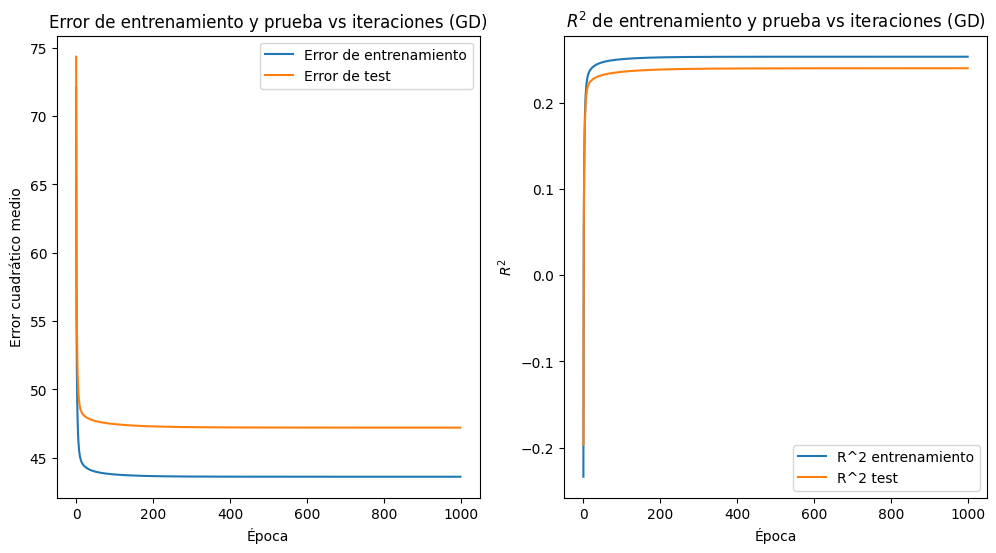

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época
    r2_train = []      # Para almacenar R^2 del entrenamiento
    r2_test = []       # Para almacenar R^2 del test

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)
        r2_train.append(1 - np.sum(error_train ** 2) / np.sum((y_train - np.mean(y_train)) ** 2))

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)
        r2_test.append(1 - np.sum(error_test ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de test')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')

    # Graficar R^2 de entrenamiento y prueba
    plt.subplot(1, 2, 2)
    plt.plot(r2_train, label='R^2 entrenamiento')
    plt.plot(r2_test, label='R^2 test')
    plt.xlabel('Época')
    plt.ylabel('$R^2$')
    plt.legend()
    plt.title('$R^2$ de entrenamiento y prueba vs iteraciones (GD)')

    plt.show()

    return W
X_train_des, X_test_des, y_train_des, y_test_des = train_test_split(X_train_reg_processed, y_train_reg.values.reshape(-1,1) , random_state=42)
w = gradient_descent(X_train_des, y_train_des, X_test_des, y_test_des, lr=0.15, epochs=1000)

#Con este método se alcanza un comportamiento similar en train y test

In [41]:
X = X_train_reg_processed
y = y_train_reg

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV

lassoCV = LassoCV()  # alpha controla la fuerza de la regularización L1 (Lasso)
ridgeCV = RidgeCV()  # alpha controla la fuerza de la regularización L2 (Ridge)
elasticnetCV = ElasticNetCV()

# Ajustar modelos a los datos
lassoCV.fit(X, y)
ridgeCV.fit(X, y)
elasticnetCV.fit(X,y)

#Mostrar alphas
print(lassoCV.alpha_)
print(ridgeCV.alpha_)
print(elasticnetCV.alpha_ )

# Mostrar coeficientes
print("\nCoeficientes del modelo Lasso:")
print(lassoCV.score(X,y))

print("\nCoeficientes del modelo Ridge:")
print(ridgeCV.score(X,y))


print("\nCoeficientes del modelo ElasticNet:")
print(elasticnetCV.score(X,y))

0.012235700595193756
10.0
0.00565321106925646

Coeficientes del modelo Lasso:
0.25039371326071047

Coeficientes del modelo Ridge:
0.2507831156466148

Coeficientes del modelo ElasticNet:
0.2505664175145187


In [42]:
y_pred_lasso = lassoCV.predict(X_test_reg_processed)
y_pred_ridge = ridgeCV.predict(X_test_reg_processed)
y_pred_elasticnet = elasticnetCV.predict(X_test_reg_processed)

# Calcular métricas de evaluación
mse_lasso = mean_squared_error(y_test_reg, y_pred_lasso)
r2_lasso = r2_score(y_test_reg, y_pred_lasso)

mse_ridge = mean_squared_error(y_test_reg, y_pred_ridge)
r2_ridge = r2_score(y_test_reg, y_pred_ridge)

mse_elasticnet = mean_squared_error(y_test_reg, y_pred_elasticnet)
r2_elasticnet = r2_score(y_test_reg, y_pred_elasticnet)

# Imprimir métricas de evaluación
print("MSE Lasso en test:", mse_lasso)
print("R^2 Lasso en test:", r2_lasso)

print("MSE Ridge en test:", mse_ridge)
print("R^2 Ridge en test:", r2_ridge)

print("MSE ElasticNet en test:", mse_elasticnet)
print("R^2 ElasticNet en test:", r2_elasticnet)

print('----------------------------------------------------------------------')
y_pred_lasso = lassoCV.predict(X_train_reg_processed)
y_pred_ridge = ridgeCV.predict(X_train_reg_processed)
y_pred_elasticnet = elasticnetCV.predict(X_train_reg_processed)

mse_lasso = mean_squared_error(y_train_reg, y_pred_lasso)
r2_lasso = r2_score(y_train_reg, y_pred_lasso)

mse_ridge = mean_squared_error(y_train_reg, y_pred_ridge)
r2_ridge = r2_score(y_train_reg, y_pred_ridge)

mse_elasticnet = mean_squared_error(y_train_reg, y_pred_elasticnet)
r2_elasticnet = r2_score(y_train_reg, y_pred_elasticnet)

print("MSE Lasso en train:", mse_lasso)
print("R^2 Lasso en train:", r2_lasso)

print("MSE Ridge en train:", mse_ridge)
print("R^2 Ridge en train:", r2_ridge)

print("MSE ElasticNet en train:", mse_elasticnet)
print("R^2 ElasticNet en train:", r2_elasticnet)

#No se notan cambios en el rendimiento de la regresion lineal luego de regularizar

MSE Lasso en test: 15.664826145814885
R^2 Lasso en test: 0.07916138461515532
MSE Ridge en test: 15.82708127263843
R^2 Ridge en test: 0.06962340539135126
MSE ElasticNet en test: 15.738980433462041
R^2 ElasticNet en test: 0.07480231092188627
----------------------------------------------------------------------
MSE Lasso en train: 44.498004424546004
R^2 Lasso en train: 0.25039371326071047
MSE Ridge en train: 44.47488878451279
R^2 Ridge en train: 0.2507831156466148
MSE ElasticNet en train: 44.48775238319304
R^2 ElasticNet en train: 0.2505664175145187


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc


logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_cla_processed, y_train_cla)
y_pred = logistic_model.predict(X_test_cla_processed)

y_probs = logistic_model.predict_proba(X_test_cla_processed)[:, 1]

#Creo un modelo de regresión logística para clasificación

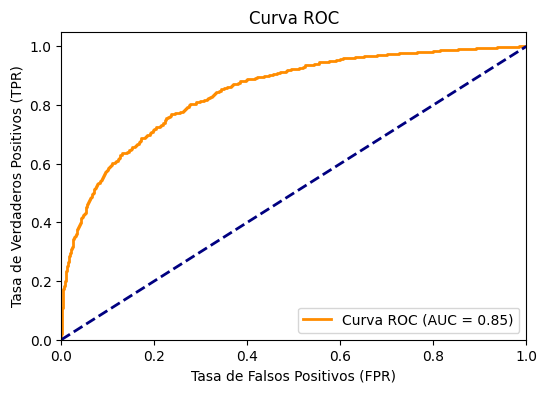

In [44]:
fpr, tpr, thresholds = roc_curve(y_test_cla, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#En la curva ROC se puede observar que el modelo se comporta mucho mejor que un predictor aleatorio
#Encontraremos el mejor umbral para nuestras necesidades a continuación

In [45]:
accuracy = accuracy_score(y_test_cla, y_pred)
precision = precision_score(y_test_cla, y_pred)
recall = recall_score(y_test_cla, y_pred)
f1 = f1_score(y_test_cla, y_pred)
confusion = confusion_matrix(y_test_cla, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.7706600110926234
Precision: 0.49022801302931596
Recall: 0.7496886674968867
F1 Score: 0.5928114229443624
Confusion Matrix:
[[2177  626]
 [ 201  602]]


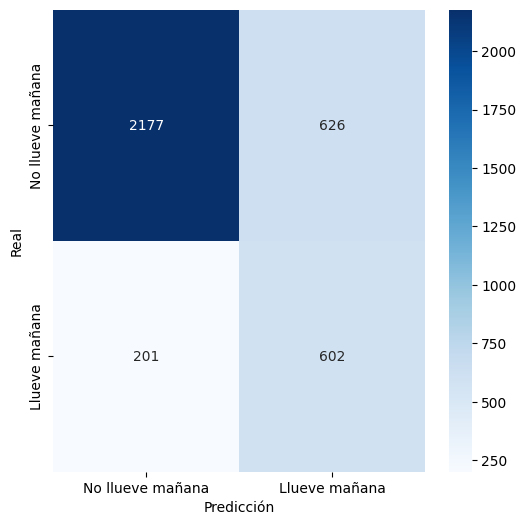

In [46]:
class_labels = ["No llueve mañana", "Llueve mañana"]

plt.figure(figsize=(6, 6))

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()

#Veo las métricas para el umbral por defecto (0.5)

In [47]:
f1_max = 0
mejor_umbral = 0
y_probs = logistic_model.predict_proba(X_test_cla_processed)[:, 1]
for nuevo_umbral in np.arange(0, 1, 0.01):
  y_pred_nuevo_umbral = (y_probs >= nuevo_umbral).astype(int)
  f1 = f1_score(y_test_cla, y_pred_nuevo_umbral)
  if f1 > f1_max:
    f1_max = f1
    mejor_umbral = nuevo_umbral

print(f"F1 Score: {f1_max}")
print(f"Mejor umbral: {mejor_umbral}")

#Encuentro el mejor umbral para maximizar el F1 Score, dado que el dataset está desbalanceado me interesa mejorar esta métrica

F1 Score: 0.6070785842831433
Mejor umbral: 0.64


In [48]:
y_probs = logistic_model.predict_proba(X_test_cla_processed)[:, 1]


nuevo_umbral = 0.64

# Clasificar las predicciones en base al nuevo umbral
y_pred_nuevo_umbral = (y_probs >= nuevo_umbral).astype(int)

accuracy = accuracy_score(y_test_cla, y_pred_nuevo_umbral)
precision = precision_score(y_test_cla, y_pred_nuevo_umbral)
recall = recall_score(y_test_cla, y_pred_nuevo_umbral)
f1 = f1_score(y_test_cla, y_pred_nuevo_umbral)
confusion = confusion_matrix(y_test_cla, y_pred_nuevo_umbral)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.8183582917359956
Precision: 0.5856481481481481
Recall: 0.6301369863013698
F1 Score: 0.6070785842831433
Confusion Matrix:
[[2445  358]
 [ 297  506]]


In [49]:
y_probs = logistic_model.predict_proba(X_train_cla_processed)[:, 1]


nuevo_umbral = 0.64

# Clasificar las predicciones en base al nuevo umbral
y_pred_nuevo_umbral = (y_probs >= nuevo_umbral).astype(int)

accuracy = accuracy_score(y_train_cla, y_pred_nuevo_umbral)
precision = precision_score(y_train_cla, y_pred_nuevo_umbral)
recall = recall_score(y_train_cla, y_pred_nuevo_umbral)
f1 = f1_score(y_train_cla, y_pred_nuevo_umbral)
confusion = confusion_matrix(y_train_cla, y_pred_nuevo_umbral)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion)

#Vemos que las metricas en el conjunto de train son similares a las de test, hay muy poco overfitting

Accuracy: 0.8298890429958391
Precision: 0.6155177386789732
Recall: 0.6558082360172096
F1 Score: 0.6350245499181669
Confusion Matrix:
[[9833 1333]
 [1120 2134]]


#Modelos base

Para el diseño de un modelo base de regresión simplemente usé la media, ya que es de las mejores opciones para calcular de forma rápida una aproximación de un valor.

Para la clasificación simplemente tomé la clase mayoritaria por ser un dataset desbalanceado, pero una opción que habría tenido mejor recall y f1 score habría sido elegir lo mismo que el día anterior (si hoy llueve mañana también, y si no, no lloverá).

In [50]:
#Modelos base

#Para el modelo base de regresion elegí hacer la media del rainfall

media = df3['Rainfall'].mean()
y_pred_base = np.array([media] * len(y_test_reg))

mse_rainfall_tomorrow = mean_squared_error(y_test_reg, y_pred_base)
r2_rainfall_tomorrow = r2_score(y_test_reg, y_pred_base)


print(f'MSE Rainfall Tomorrow en Test: {mse_rainfall_tomorrow}')
print(f'R^2 Rainfall Tomorrow en Test: {r2_rainfall_tomorrow}')

#La media es el estadístico que mejor predice en un problema de regresión, con un r^2 de virtualmente 0

MSE Rainfall Tomorrow en Test: 17.657130305176224
R^2 Rainfall Tomorrow en Test: -0.03795390198008741


In [51]:
#Para elegir un modelo base en la clasificación simplemente elijo la clase mayoritaria

valor_mas_comun = y_train_cla.value_counts().idxmax()
valores = np.array([valor_mas_comun] * len(y_test_cla))

accuracy = accuracy_score(y_test_cla, valores)
precision = precision_score(y_test_cla, valores)
recall = recall_score(y_test_cla, valores)
f1 = f1_score(y_test_cla, valores)
confusion = confusion_matrix(y_test_cla, valores)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.7773155851358846
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2803    0]
 [ 803    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Redes neuronales

Hice dos redes neuronales, una para clasificación y otra para regresión, y fueron los modelos utilizados para la puesta en producción. Para la optimización de hiperparametros utilicé optuna, ya que es un punto medio entre la eficiencia de rendimiento que ofrece gridsearch y la rapidez de randomsearch.

Los modelos de redes neuronales terminaron teniendo un rendimiento bastante similar (en r2 para regresiony f1 score para clasificacion) que las regresión líneal y la regresión logística.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 208       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
361/361 [===

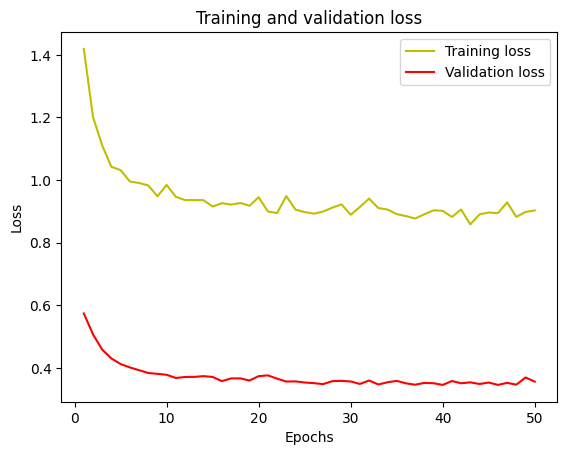

113/113 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.2922536930201664
Mean Squared Error: 0.24569474603991026
Root Mean Squared Error: 0.4956760494919139
R2: 0.14264412511948932


In [53]:
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# Crear el modelo
model2 = Sequential()
model2.add(Dense(8, activation='relu', input_shape=(25,), kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.5))
model2.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='linear'))

# Compilar el modelo
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Resumen del modelo
model2.summary()

# Entrenar el modelo con EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model2.fit(X_train_reg_processed, y_train_reg_scaled , validation_split=0.2, epochs =100, callbacks=[early_stop])

# Graficar la pérdida de entrenamiento y validación
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predecir en el conjunto de prueba
y_pred = model2.predict(X_test_reg_processed)

# Calcular el error absoluto medio, el error cuadrado medio y la raíz del error cuadrado medio
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_reg_scaled, y_pred)
mse = mean_squared_error(y_test_reg_scaled, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg_scaled, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2: {r2}')

In [54]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [55]:
!pip install optuna-integration

In [116]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import optuna
from optuna.integration import TFKerasPruningCallback
import numpy as np

# Definición de la función para construir el modelo
def build_model(trial):
    model = keras.Sequential()

    # Número de unidades en la primera capa oculta
    num_units_1 = trial.suggest_int('num_units_1', 4, 12, step=2)
    # Dropout rate en la primera capa oculta
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.5, step=0.1)

    # Capa densa 1
    model.add(layers.Dense(units=num_units_1, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(rate=dropout_rate_1))

    # Número de unidades en la segunda capa oculta
    num_units_2 = trial.suggest_int('num_units_2', 4, 12, step=2)
    # Dropout rate en la segunda capa oculta
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.5, step=0.1)

    # Capa densa 2
    model.add(layers.Dense(units=num_units_2, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(rate=dropout_rate_2))

    # Capa de salida
    model.add(layers.Dense(1, activation='linear'))

    # Compilar el modelo
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

# Función de objetivo para la optimización de Optuna
def objective(trial):
    # División del conjunto de entrenamiento para validación
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_reg_processed, y_train_reg_scaled, test_size=0.2)

    # Construir el modelo con los parámetros sugeridos por Optuna
    model = build_model(trial)

    # Entrenamiento del modelo
    model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              epochs=100,
              callbacks=[TFKerasPruningCallback(trial, 'val_loss')])

    # Evaluación del modelo en el conjunto de validación
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score[0]  # Se devuelve el valor de pérdida

# Crear un estudio Optuna y ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Imprimir los mejores hiperparámetros encontrados
best_trial = study.best_trial
print("Mejores hiperparámetros encontrados:")
print("  Valor de pérdida: {}".format(best_trial.value))
print("  Parámetros:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))



[I 2024-03-03 23:31:01,138] A new study created in memory with name: no-name-e0f30130-0220-44a9-9fcf-b425356f202d


Epoch 1/100
361/361 [==============================] - 2s 3ms/step - loss: 1.2264 - mae: 0.4900 - val_loss: 1.0530 - val_mae: 0.4290
Epoch 2/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9989 - mae: 0.4243 - val_loss: 0.8903 - val_mae: 0.4056
Epoch 3/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9157 - mae: 0.3985 - val_loss: 0.8412 - val_mae: 0.3829
Epoch 4/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8685 - mae: 0.3848 - val_loss: 0.8072 - val_mae: 0.3771
Epoch 5/100
361/361 [==============================] - 1s 4ms/step - loss: 0.8304 - mae: 0.3740 - val_loss: 0.7874 - val_mae: 0.3739
Epoch 6/100
361/361 [==============================] - 1s 4ms/step - loss: 0.8125 - mae: 0.3677 - val_loss: 0.7811 - val_mae: 0.3546
Epoch 7/100
361/361 [==============================] - 2s 6ms/step - loss: 0.8161 - mae: 0.3661 - val_loss: 0.7790 - val_mae: 0.3608
Epoch 8/100
361/361 [==============================] - 3s 7ms/step - 

[I 2024-03-03 23:33:24,151] Trial 0 finished with value: 0.7124631404876709 and parameters: {'num_units_1': 10, 'dropout_rate_1': 0.0, 'num_units_2': 8, 'dropout_rate_2': 0.5}. Best is trial 0 with value: 0.7124631404876709.


Epoch 1/100
361/361 [==============================] - 2s 3ms/step - loss: 1.3650 - mae: 0.5866 - val_loss: 0.9847 - val_mae: 0.4489
Epoch 2/100
361/361 [==============================] - 1s 2ms/step - loss: 1.0388 - mae: 0.4536 - val_loss: 0.9031 - val_mae: 0.4077
Epoch 3/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9447 - mae: 0.4106 - val_loss: 0.8457 - val_mae: 0.3861
Epoch 4/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8558 - mae: 0.3855 - val_loss: 0.7939 - val_mae: 0.3580
Epoch 5/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8198 - mae: 0.3644 - val_loss: 0.7604 - val_mae: 0.3482
Epoch 6/100
361/361 [==============================] - 1s 2ms/step - loss: 0.7959 - mae: 0.3536 - val_loss: 0.7471 - val_mae: 0.3294
Epoch 7/100
361/361 [==============================] - 1s 2ms/step - loss: 0.7849 - mae: 0.3447 - val_loss: 0.7288 - val_mae: 0.3444
Epoch 8/100
361/361 [==============================] - 1s 2ms/step - 

[I 2024-03-03 23:35:47,176] Trial 1 finished with value: 0.675963282585144 and parameters: {'num_units_1': 12, 'dropout_rate_1': 0.2, 'num_units_2': 8, 'dropout_rate_2': 0.1}. Best is trial 1 with value: 0.675963282585144.


Epoch 1/100
361/361 [==============================] - 2s 4ms/step - loss: 1.2597 - mae: 0.5667 - val_loss: 0.9777 - val_mae: 0.4251
Epoch 2/100
361/361 [==============================] - 1s 4ms/step - loss: 1.0480 - mae: 0.4665 - val_loss: 0.9061 - val_mae: 0.4140
Epoch 3/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9780 - mae: 0.4407 - val_loss: 0.8604 - val_mae: 0.3938
Epoch 4/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9224 - mae: 0.4207 - val_loss: 0.8236 - val_mae: 0.3711
Epoch 5/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9161 - mae: 0.4097 - val_loss: 0.7938 - val_mae: 0.3738
Epoch 6/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8678 - mae: 0.3975 - val_loss: 0.7849 - val_mae: 0.3592
Epoch 7/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8595 - mae: 0.3931 - val_loss: 0.7642 - val_mae: 0.3539
Epoch 8/100
361/361 [==============================] - 1s 2ms/step - 

[I 2024-03-03 23:37:18,977] Trial 2 finished with value: 0.6944841146469116 and parameters: {'num_units_1': 6, 'dropout_rate_1': 0.4, 'num_units_2': 10, 'dropout_rate_2': 0.30000000000000004}. Best is trial 1 with value: 0.675963282585144.


Epoch 1/100
361/361 [==============================] - 2s 3ms/step - loss: 1.6394 - mae: 0.6268 - val_loss: 1.1946 - val_mae: 0.4505
Epoch 2/100
361/361 [==============================] - 1s 2ms/step - loss: 1.0897 - mae: 0.4500 - val_loss: 1.1412 - val_mae: 0.4506
Epoch 3/100
361/361 [==============================] - 1s 2ms/step - loss: 1.0399 - mae: 0.4399 - val_loss: 1.0761 - val_mae: 0.4463
Epoch 4/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9871 - mae: 0.4290 - val_loss: 0.9991 - val_mae: 0.4354
Epoch 5/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9414 - mae: 0.4152 - val_loss: 0.9653 - val_mae: 0.4268
Epoch 6/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8730 - mae: 0.4023 - val_loss: 0.8946 - val_mae: 0.4080
Epoch 7/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8569 - mae: 0.3856 - val_loss: 0.8838 - val_mae: 0.3952
Epoch 8/100
361/361 [==============================] - 1s 2ms/step - 

[I 2024-03-03 23:38:50,603] Trial 3 finished with value: 0.800127387046814 and parameters: {'num_units_1': 12, 'dropout_rate_1': 0.2, 'num_units_2': 4, 'dropout_rate_2': 0.5}. Best is trial 1 with value: 0.675963282585144.


Epoch 1/100
361/361 [==============================] - 2s 3ms/step - loss: 1.3856 - mae: 0.5762 - val_loss: 1.1706 - val_mae: 0.4016
Epoch 2/100
361/361 [==============================] - 1s 2ms/step - loss: 1.0666 - mae: 0.4490 - val_loss: 1.0475 - val_mae: 0.3951
Epoch 3/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9503 - mae: 0.4158 - val_loss: 0.9505 - val_mae: 0.3738
Epoch 4/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8944 - mae: 0.3941 - val_loss: 0.9192 - val_mae: 0.3521
Epoch 5/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8448 - mae: 0.3747 - val_loss: 0.8913 - val_mae: 0.3439
Epoch 6/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8058 - mae: 0.3720 - val_loss: 0.8521 - val_mae: 0.3447
Epoch 7/100
361/361 [==============================] - 1s 2ms/step - loss: 0.7714 - mae: 0.3611 - val_loss: 0.8341 - val_mae: 0.3509
Epoch 8/100
361/361 [==============================] - 1s 2ms/step - 

[I 2024-03-03 23:41:13,572] Trial 4 finished with value: 0.7523053884506226 and parameters: {'num_units_1': 12, 'dropout_rate_1': 0.4, 'num_units_2': 10, 'dropout_rate_2': 0.4}. Best is trial 1 with value: 0.675963282585144.


Epoch 1/100
361/361 [==============================] - 2s 3ms/step - loss: 1.1076 - mae: 0.4661 - val_loss: 1.0122 - val_mae: 0.4184
Epoch 2/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9256 - mae: 0.4068 - val_loss: 0.8883 - val_mae: 0.3684
Epoch 3/100
361/361 [==============================] - 1s 3ms/step - loss: 0.8538 - mae: 0.3759 - val_loss: 0.8180 - val_mae: 0.3729
Epoch 4/100
361/361 [==============================] - 1s 4ms/step - loss: 0.8089 - mae: 0.3641 - val_loss: 0.7864 - val_mae: 0.3422
Epoch 5/100
361/361 [==============================] - 1s 3ms/step - loss: 0.7926 - mae: 0.3537 - val_loss: 0.7670 - val_mae: 0.3309
Epoch 6/100
361/361 [==============================] - 1s 2ms/step - loss: 0.7479 - mae: 0.3454 - val_loss: 0.7394 - val_mae: 0.3261
Epoch 7/100
361/361 [==============================] - 1s 2ms/step - loss: 0.7442 - mae: 0.3445 - val_loss: 0.7278 - val_mae: 0.3340
Epoch 8/100
361/361 [==============================] - 1s 2ms/step - 

[I 2024-03-03 23:43:36,593] Trial 5 finished with value: 0.6513972878456116 and parameters: {'num_units_1': 12, 'dropout_rate_1': 0.1, 'num_units_2': 4, 'dropout_rate_2': 0.1}. Best is trial 5 with value: 0.6513972878456116.


Epoch 1/100
361/361 [==============================] - 2s 3ms/step - loss: 1.2062 - mae: 0.5126 - val_loss: 0.9702 - val_mae: 0.4597
Epoch 2/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9641 - mae: 0.4484 - val_loss: 0.8460 - val_mae: 0.4131
Epoch 3/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8809 - mae: 0.4012 - val_loss: 0.7985 - val_mae: 0.3665
Epoch 4/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8330 - mae: 0.3719 - val_loss: 0.7639 - val_mae: 0.3536
Epoch 5/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8043 - mae: 0.3583 - val_loss: 0.7340 - val_mae: 0.3636
Epoch 6/100
361/361 [==============================] - 1s 2ms/step - loss: 0.7984 - mae: 0.3578 - val_loss: 0.7216 - val_mae: 0.3505
Epoch 7/100
361/361 [==============================] - 1s 2ms/step - loss: 0.7783 - mae: 0.3543 - val_loss: 0.7051 - val_mae: 0.3352
Epoch 8/100
361/361 [==============================] - 1s 2ms/step - 

[I 2024-03-03 23:45:59,585] Trial 6 finished with value: 0.6319792866706848 and parameters: {'num_units_1': 6, 'dropout_rate_1': 0.0, 'num_units_2': 10, 'dropout_rate_2': 0.4}. Best is trial 6 with value: 0.6319792866706848.


Epoch 1/100
361/361 [==============================] - 2s 4ms/step - loss: 1.3493 - mae: 0.5821 - val_loss: 0.9018 - val_mae: 0.4296
Epoch 2/100
361/361 [==============================] - 1s 4ms/step - loss: 1.0972 - mae: 0.4752 - val_loss: 0.7873 - val_mae: 0.4205
Epoch 3/100
361/361 [==============================] - 1s 3ms/step - loss: 0.9940 - mae: 0.4350 - val_loss: 0.7206 - val_mae: 0.3838
Epoch 4/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9412 - mae: 0.4073 - val_loss: 0.6794 - val_mae: 0.3705
Epoch 5/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9084 - mae: 0.3958 - val_loss: 0.6439 - val_mae: 0.3476
Epoch 6/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8635 - mae: 0.3809 - val_loss: 0.6150 - val_mae: 0.3535
Epoch 7/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8375 - mae: 0.3766 - val_loss: 0.5988 - val_mae: 0.3392
Epoch 8/100
361/361 [==============================] - 1s 2ms/step - 

[I 2024-03-03 23:48:22,550] Trial 7 finished with value: 0.5645269155502319 and parameters: {'num_units_1': 8, 'dropout_rate_1': 0.4, 'num_units_2': 8, 'dropout_rate_2': 0.2}. Best is trial 7 with value: 0.5645269155502319.


Epoch 1/100
357/361 [============================>.] - ETA: 0s - loss: 1.2149 - mae: 0.5327

[I 2024-03-03 23:48:24,344] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/100
361/361 [==============================] - 2s 3ms/step - loss: 1.3544 - mae: 0.5238 - val_loss: 0.9592 - val_mae: 0.4048
Epoch 2/100
361/361 [==============================] - 1s 2ms/step - loss: 1.0831 - mae: 0.4428 - val_loss: 0.7675 - val_mae: 0.3629
Epoch 3/100
361/361 [==============================] - 1s 2ms/step - loss: 0.9603 - mae: 0.4034 - val_loss: 0.7208 - val_mae: 0.3421
Epoch 4/100
361/361 [==============================] - 1s 2ms/step - loss: 0.8805 - mae: 0.3828 - val_loss: 0.6634 - val_mae: 0.3428
Epoch 5/100
361/361 [==============================] - 1s 4ms/step - loss: 0.8576 - mae: 0.3733 - val_loss: 0.6433 - val_mae: 0.3369
Epoch 6/100
361/361 [==============================] - 1s 4ms/step - loss: 0.8260 - mae: 0.3637 - val_loss: 0.6194 - val_mae: 0.3347
Epoch 7/100
361/361 [==============================] - 1s 2ms/step - loss: 0.7955 - mae: 0.3591 - val_loss: 0.6252 - val_mae: 0.3090
Epoch 8/100
361/361 [==============================] - 1s 2ms/step - 

[I 2024-03-03 23:49:56,826] Trial 9 finished with value: 0.592971682548523 and parameters: {'num_units_1': 12, 'dropout_rate_1': 0.2, 'num_units_2': 12, 'dropout_rate_2': 0.4}. Best is trial 7 with value: 0.5645269155502319.


Mejores hiperparámetros encontrados:
  Valor de pérdida: 0.5645269155502319
  Parámetros:
    num_units_1: 8
    dropout_rate_1: 0.4
    num_units_2: 8
    dropout_rate_2: 0.2


In [118]:
# Obtener el mejor ensayo (trial) de Optuna
best_trial = study.best_trial

# Construir el modelo final con los mejores hiperparámetros
final_model = build_model(best_trial)

# Entrenar el modelo final en todo el conjunto de datos de entrenamiento
final_model.fit(X_train_reg_processed, y_train_reg_scaled, epochs=100)

# Evaluar el modelo final en el conjunto de prueba
test_loss, test_mae = final_model.evaluate(X_test_reg_processed, y_test_reg_scaled)

# Predecir en el conjunto de prueba
y_pred = final_model.predict(X_test_reg_processed)

# Calcular el coeficiente de determinación (R cuadrado)
r2 = r2_score(y_test_reg_scaled, y_pred)
print("Pérdida en el conjunto de prueba:", test_loss)
print("Error absoluto medio en el conjunto de prueba:", test_mae)
print("Coeficiente de determinación (R^2) en el conjunto de prueba:", r2)

Epoch 1/100
451/451 [==============================] - 3s 3ms/step - loss: 1.3386 - mae: 0.5630
Epoch 2/100
451/451 [==============================] - 4s 8ms/step - loss: 1.0585 - mae: 0.4690
Epoch 3/100
451/451 [==============================] - 3s 6ms/step - loss: 0.9849 - mae: 0.4344
Epoch 4/100
451/451 [==============================] - 2s 5ms/step - loss: 0.9300 - mae: 0.4121
Epoch 5/100
451/451 [==============================] - 2s 5ms/step - loss: 0.8604 - mae: 0.3944
Epoch 6/100
451/451 [==============================] - 2s 4ms/step - loss: 0.8198 - mae: 0.3821
Epoch 7/100
451/451 [==============================] - 1s 2ms/step - loss: 0.8142 - mae: 0.3746
Epoch 8/100
451/451 [==============================] - 1s 2ms/step - loss: 0.8127 - mae: 0.3747
Epoch 9/100
451/451 [==============================] - 1s 2ms/step - loss: 0.7874 - mae: 0.3699
Epoch 10/100
451/451 [==============================] - 1s 3ms/step - loss: 0.7846 - mae: 0.3683
Epoch 11/100
451/451 [=================

In [120]:
model_path = 'best_model_regression.keras'
final_model.save(model_path)
print("Modelo guardado exitosamente en:", model_path)

Modelo guardado exitosamente en: best_model_regression.keras


In [56]:
import numpy as np
import tensorflow as tf

# Calcular la proporción de las clases en el conjunto de entrenamiento
class_counts = np.bincount(y_train_cla)
total_samples = np.sum(class_counts)
class_proportions = class_counts / total_samples

# Calcular los pesos de clase inversamente proporcionales
class_weights = {i: total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))}

# Crear el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(25,)),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo con class_weights
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])

# Entrenar el modelo con class_weights
model.fit(X_train_cla_processed, y_train_cla, epochs=100, batch_size=32, validation_data=(X_test_cla_processed, y_test_cla), class_weight=class_weights)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy, recall = model.evaluate(X_test_cla_processed, y_test_cla)
print(f'Pérdida test: {loss}')
print(f'Exactitud test: {accuracy}')
print(f'Recall test, {recall}')


Epoch 1/100
451/451 [==============================] - 2s 3ms/step - loss: 0.6179 - accuracy: 0.7596 - recall: 0.5836 - val_loss: 0.5639 - val_accuracy: 0.6913 - val_recall: 0.8269
Epoch 2/100
451/451 [==============================] - 1s 3ms/step - loss: 0.4970 - accuracy: 0.7480 - recall: 0.8153 - val_loss: 0.5210 - val_accuracy: 0.7205 - val_recall: 0.8194
Epoch 3/100
451/451 [==============================] - 2s 4ms/step - loss: 0.4770 - accuracy: 0.7577 - recall: 0.8147 - val_loss: 0.5220 - val_accuracy: 0.7268 - val_recall: 0.8207
Epoch 4/100
451/451 [==============================] - 2s 3ms/step - loss: 0.4680 - accuracy: 0.7646 - recall: 0.8128 - val_loss: 0.5061 - val_accuracy: 0.7396 - val_recall: 0.8020
Epoch 5/100
451/451 [==============================] - 1s 3ms/step - loss: 0.4629 - accuracy: 0.7709 - recall: 0.8092 - val_loss: 0.4702 - val_accuracy: 0.7604 - val_recall: 0.7547
Epoch 6/100
451/451 [==============================] - 1s 2ms/step - loss: 0.4607 - accuracy: 0

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predecir las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test_cla_processed)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convertir probabilidades en etiquetas binarias

# Calcular métricas
accuracy = accuracy_score(y_test_cla, y_pred_binary)
precision = precision_score(y_test_cla, y_pred_binary)
recall = recall_score(y_test_cla, y_pred_binary)
f1 = f1_score(y_test_cla, y_pred_binary)

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_test_cla, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


113/113 [==============================] - 0s 1ms/step
Accuracy: 0.7778702163061564
Precision: 0.5008305647840532
Recall: 0.75093399750934
F1 Score: 0.600896860986547
Confusion Matrix:
[[2202  601]
 [ 200  603]]


In [137]:
import optuna
import tensorflow as tf
from sklearn.metrics import f1_score

def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    units_1 = trial.suggest_int('units_1', 8, 72, step=16)
    units_2 = trial.suggest_int('units_2', 8, 72, step=16)
    dropout_1 = trial.suggest_float('dropout_1', 0.0, 0.5, step=0.1)
    dropout_2 = trial.suggest_float('dropout_2', 0.0, 0.5, step=0.1)

    # Crear el modelo
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units_1, activation='relu', input_shape=(25,)),
        tf.keras.layers.Dropout(dropout_1),
        tf.keras.layers.Dense(units_2, activation='relu'),
        tf.keras.layers.Dropout(dropout_2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(X_train_cla_processed, y_train_cla, epochs=20, batch_size=32, verbose=0)

    # Predecir las etiquetas para el conjunto de prueba
    y_pred = model.predict(X_test_cla_processed)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calcular F1 Score
    f1 = f1_score(y_test_cla, y_pred_binary)

    return f1

# Crear un estudio Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los mejores hiperparámetros y su puntuación F1 correspondiente
print('Best trial:')
best_trial = study.best_trial
print('  Value: {}'.format(best_trial.value))
print('  Params: ')
for key, value in best_trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2024-03-04 00:28:54,224] A new study created in memory with name: no-name-cd1e3458-1788-4b4c-9cfb-3f4ff971ff9a


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:29:15,950] Trial 0 finished with value: 0.5664913598797896 and parameters: {'units_1': 8, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.5}. Best is trial 0 with value: 0.5664913598797896.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:29:33,922] Trial 1 finished with value: 0.5712062256809338 and parameters: {'units_1': 56, 'units_2': 24, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.1}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:29:50,067] Trial 2 finished with value: 0.554858934169279 and parameters: {'units_1': 8, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.5}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:30:11,970] Trial 3 finished with value: 0.4551111111111111 and parameters: {'units_1': 24, 'units_2': 24, 'dropout_1': 0.5, 'dropout_2': 0.1}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:30:28,064] Trial 4 finished with value: 0.5221674876847291 and parameters: {'units_1': 8, 'units_2': 24, 'dropout_1': 0.2, 'dropout_2': 0.1}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:30:44,990] Trial 5 finished with value: 0.533988533988534 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.4, 'dropout_2': 0.30000000000000004}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:31:07,029] Trial 6 finished with value: 0.5619967793880838 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.30000000000000004}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:31:23,574] Trial 7 finished with value: 0.5372645372645373 and parameters: {'units_1': 72, 'units_2': 8, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.4}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:31:41,022] Trial 8 finished with value: 0.547486033519553 and parameters: {'units_1': 8, 'units_2': 72, 'dropout_1': 0.1, 'dropout_2': 0.4}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:32:02,895] Trial 9 finished with value: 0.5545675020210186 and parameters: {'units_1': 72, 'units_2': 24, 'dropout_1': 0.5, 'dropout_2': 0.30000000000000004}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:32:24,699] Trial 10 finished with value: 0.5701006971340046 and parameters: {'units_1': 40, 'units_2': 8, 'dropout_1': 0.2, 'dropout_2': 0.0}. Best is trial 1 with value: 0.5712062256809338.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:32:41,396] Trial 11 finished with value: 0.5818452380952381 and parameters: {'units_1': 40, 'units_2': 8, 'dropout_1': 0.2, 'dropout_2': 0.0}. Best is trial 11 with value: 0.5818452380952381.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:32:57,361] Trial 12 finished with value: 0.5727136431784108 and parameters: {'units_1': 40, 'units_2': 8, 'dropout_1': 0.2, 'dropout_2': 0.0}. Best is trial 11 with value: 0.5818452380952381.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:33:19,155] Trial 13 finished with value: 0.5709969788519638 and parameters: {'units_1': 40, 'units_2': 8, 'dropout_1': 0.1, 'dropout_2': 0.0}. Best is trial 11 with value: 0.5818452380952381.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:33:40,989] Trial 14 finished with value: 0.5796226415094339 and parameters: {'units_1': 24, 'units_2': 8, 'dropout_1': 0.1, 'dropout_2': 0.0}. Best is trial 11 with value: 0.5818452380952381.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:33:58,033] Trial 15 finished with value: 0.5725190839694656 and parameters: {'units_1': 24, 'units_2': 8, 'dropout_1': 0.1, 'dropout_2': 0.2}. Best is trial 11 with value: 0.5818452380952381.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:34:19,936] Trial 16 finished with value: 0.5885841363973313 and parameters: {'units_1': 24, 'units_2': 56, 'dropout_1': 0.1, 'dropout_2': 0.2}. Best is trial 16 with value: 0.5885841363973313.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:34:37,046] Trial 17 finished with value: 0.5821455363840959 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 16 with value: 0.5885841363973313.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:34:53,494] Trial 18 finished with value: 0.5955882352941178 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 18 with value: 0.5955882352941178.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:35:09,930] Trial 19 finished with value: 0.5898959881129272 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 18 with value: 0.5955882352941178.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:35:26,965] Trial 20 finished with value: 0.5733840304182509 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 18 with value: 0.5955882352941178.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:35:43,296] Trial 21 finished with value: 0.6022889842632332 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 21 with value: 0.6022889842632332.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:36:05,087] Trial 22 finished with value: 0.5775165319617929 and parameters: {'units_1': 56, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 21 with value: 0.6022889842632332.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:36:21,561] Trial 23 finished with value: 0.6125874125874127 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:36:38,181] Trial 24 finished with value: 0.5542168674698795 and parameters: {'units_1': 56, 'units_2': 40, 'dropout_1': 0.1, 'dropout_2': 0.30000000000000004}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:36:55,288] Trial 25 finished with value: 0.58719646799117 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.4}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:37:13,868] Trial 26 finished with value: 0.6061433447098976 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:37:32,859] Trial 27 finished with value: 0.5922746781115878 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.1, 'dropout_2': 0.1}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:37:55,047] Trial 28 finished with value: 0.5802562170308968 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:38:13,348] Trial 29 finished with value: 0.6 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:38:35,127] Trial 30 finished with value: 0.5609561752988048 and parameters: {'units_1': 40, 'units_2': 72, 'dropout_1': 0.4, 'dropout_2': 0.2}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:38:52,488] Trial 31 finished with value: 0.5929648241206029 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:39:09,642] Trial 32 finished with value: 0.6098901098901099 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:39:27,389] Trial 33 finished with value: 0.56732223903177 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.1, 'dropout_2': 0.2}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:39:49,222] Trial 34 finished with value: 0.5797720797720798 and parameters: {'units_1': 56, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 23 with value: 0.6125874125874127.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:40:11,240] Trial 35 finished with value: 0.6288147622427254 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:40:28,930] Trial 36 finished with value: 0.5948575399583044 and parameters: {'units_1': 72, 'units_2': 24, 'dropout_1': 0.1, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:40:45,133] Trial 37 finished with value: 0.5886426592797784 and parameters: {'units_1': 56, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:41:01,584] Trial 38 finished with value: 0.5393442622950819 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.4, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:41:23,415] Trial 39 finished with value: 0.5701219512195121 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.1, 'dropout_2': 0.5}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:41:45,131] Trial 40 finished with value: 0.5861297539149888 and parameters: {'units_1': 40, 'units_2': 40, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:42:06,995] Trial 41 finished with value: 0.5788271134805788 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.30000000000000004}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:42:29,080] Trial 42 finished with value: 0.5540647198105761 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:42:50,790] Trial 43 finished with value: 0.6043878273177636 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:43:07,657] Trial 44 finished with value: 0.5789871504157218 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.1, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:43:24,031] Trial 45 finished with value: 0.6156716417910447 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:43:45,977] Trial 46 finished with value: 0.5827814569536424 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.2, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:44:07,769] Trial 47 finished with value: 0.5950413223140496 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.1, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:44:23,467] Trial 48 finished with value: 0.5777126099706744 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:44:39,530] Trial 49 finished with value: 0.5982404692082112 and parameters: {'units_1': 40, 'units_2': 24, 'dropout_1': 0.1, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:45:01,632] Trial 50 finished with value: 0.5938375350140056 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:45:18,545] Trial 51 finished with value: 0.5974395448079658 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:45:35,190] Trial 52 finished with value: 0.6020558002936858 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:45:51,303] Trial 53 finished with value: 0.5692188708430008 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:46:07,840] Trial 54 finished with value: 0.5377049180327869 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.5, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:46:24,324] Trial 55 finished with value: 0.6063604240282685 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:46:46,120] Trial 56 finished with value: 0.5831593597773138 and parameters: {'units_1': 8, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:47:08,106] Trial 57 finished with value: 0.5936395759717313 and parameters: {'units_1': 56, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:47:29,769] Trial 58 finished with value: 0.6173677069199457 and parameters: {'units_1': 40, 'units_2': 72, 'dropout_1': 0.1, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:47:52,967] Trial 59 finished with value: 0.5953757225433526 and parameters: {'units_1': 40, 'units_2': 72, 'dropout_1': 0.1, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:48:10,359] Trial 60 finished with value: 0.5804988662131518 and parameters: {'units_1': 24, 'units_2': 72, 'dropout_1': 0.2, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:48:28,116] Trial 61 finished with value: 0.5937272064186726 and parameters: {'units_1': 40, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:48:49,860] Trial 62 finished with value: 0.565015479876161 and parameters: {'units_1': 40, 'units_2': 72, 'dropout_1': 0.1, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:49:07,783] Trial 63 finished with value: 0.5931952662721893 and parameters: {'units_1': 56, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.30000000000000004}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:49:24,110] Trial 64 finished with value: 0.5980253878702398 and parameters: {'units_1': 40, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:49:45,914] Trial 65 finished with value: 0.5043177892918826 and parameters: {'units_1': 24, 'units_2': 72, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:50:03,155] Trial 66 finished with value: 0.6029935851746259 and parameters: {'units_1': 56, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:50:24,896] Trial 67 finished with value: 0.5825688073394496 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.1, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:50:46,683] Trial 68 finished with value: 0.6107784431137724 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:51:08,449] Trial 69 finished with value: 0.5994397759103641 and parameters: {'units_1': 56, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:51:25,590] Trial 70 finished with value: 0.6016949152542374 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.1, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:51:41,455] Trial 71 finished with value: 0.5683890577507599 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:52:03,142] Trial 72 finished with value: 0.5859197577592733 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:52:19,398] Trial 73 finished with value: 0.5587548638132296 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:52:41,040] Trial 74 finished with value: 0.6043068640646031 and parameters: {'units_1': 72, 'units_2': 24, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:53:02,867] Trial 75 finished with value: 0.5835156819839533 and parameters: {'units_1': 40, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:53:24,660] Trial 76 finished with value: 0.5834609494640123 and parameters: {'units_1': 56, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.30000000000000004}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:53:42,208] Trial 77 finished with value: 0.5722713864306784 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.1, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:54:03,863] Trial 78 finished with value: 0.5865724381625441 and parameters: {'units_1': 72, 'units_2': 24, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:54:26,094] Trial 79 finished with value: 0.5851462865716428 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.1, 'dropout_2': 0.4}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:54:47,808] Trial 80 finished with value: 0.578068264342774 and parameters: {'units_1': 56, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:55:04,080] Trial 81 finished with value: 0.5972323379461034 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:55:25,768] Trial 82 finished with value: 0.560490045941807 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:55:47,603] Trial 83 finished with value: 0.5586592178770949 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.2, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:56:09,438] Trial 84 finished with value: 0.6002766251728908 and parameters: {'units_1': 72, 'units_2': 40, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:56:31,399] Trial 85 finished with value: 0.6005917159763314 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:56:48,541] Trial 86 finished with value: 0.605316973415133 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:57:04,304] Trial 87 finished with value: 0.5836909871244635 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:57:20,733] Trial 88 finished with value: 0.6007272727272727 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:57:37,876] Trial 89 finished with value: 0.5525902668759812 and parameters: {'units_1': 56, 'units_2': 72, 'dropout_1': 0.1, 'dropout_2': 0.5}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:57:54,622] Trial 90 finished with value: 0.5810616929698709 and parameters: {'units_1': 40, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:58:11,153] Trial 91 finished with value: 0.563165905631659 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:58:27,506] Trial 92 finished with value: 0.543426294820717 and parameters: {'units_1': 72, 'units_2': 56, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:58:49,527] Trial 93 finished with value: 0.593150684931507 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.0}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:59:05,981] Trial 94 finished with value: 0.6061026352288489 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 00:59:28,202] Trial 95 finished with value: 0.5152542372881356 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.4, 'dropout_2': 0.1}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 2ms/step


[I 2024-03-04 00:59:44,545] Trial 96 finished with value: 0.6143527833668678 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 01:00:01,672] Trial 97 finished with value: 0.622994652406417 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 01:00:24,947] Trial 98 finished with value: 0.5494163424124513 and parameters: {'units_1': 56, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


113/113 [==============================] - 0s 1ms/step


[I 2024-03-04 01:00:42,603] Trial 99 finished with value: 0.5299837925445706 and parameters: {'units_1': 72, 'units_2': 72, 'dropout_1': 0.0, 'dropout_2': 0.2}. Best is trial 35 with value: 0.6288147622427254.


Best trial:
  Value: 0.6288147622427254
  Params: 
    units_1: 56
    units_2: 56
    dropout_1: 0.0
    dropout_2: 0.1


In [152]:
import tensorflow as tf


# Definir los mejores hiperparámetros encontrados
best_params = study.best_trial.params

# Crear y compilar el modelo con los mejores hiperparámetros
model = tf.keras.Sequential([
    tf.keras.layers.Dense(best_params['units_1'], activation='relu', input_shape=(25,)),
    tf.keras.layers.Dropout(best_params['dropout_1']),
    tf.keras.layers.Dense(best_params['units_2'], activation='relu'),
    tf.keras.layers.Dropout(best_params['dropout_2']),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])

# Entrenar el modelo con los mejores hiperparámetros
model.fit(X_train_cla_processed, y_train_cla, epochs=50, batch_size=32, verbose=0)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_cla_processed)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calcular métricas
accuracy = accuracy_score(y_test_cla, y_pred_binary)
precision = precision_score(y_test_cla, y_pred_binary)
recall = recall_score(y_test_cla, y_pred_binary)
f1 = f1_score(y_test_cla, y_pred_binary)
conf_matrix = confusion_matrix(y_test_cla, y_pred_binary)

# Imprimir métricas y matriz de confusión
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)



113/113 [==============================] - 0s 1ms/step
Accuracy: 0.8394342762063228
Precision: 0.7058823529411765
Recall: 0.47820672478206727
F1 Score: 0.5701559020044543
Confusion Matrix:
[[2643  160]
 [ 419  384]]


In [154]:
model_path = 'best_model_classification.keras'
model.save(model_path)
print("Modelo guardado exitosamente en:", model_path)

Modelo guardado exitosamente en: best_model_classification.keras


#SHAP

Mientras más complejos son los modelos, empiezan a ser muy complicados o incluso imposibles de interpretar, por ejemplo, las redes neuronales diseñadas en este trabajo. Esta librería permite entender mejor por qué el modelo se comporta como lo hace.
En el force plot se puede observar que variables empujan a predecir si mañana lloverá o no, y con qué intensidad.

In [58]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 10.6 MB/s eta 0:00:00


In [59]:
import shap
feature_names=df3.drop(columns = ['RainfallTomorrow','RainTomorrow'],axis=1).columns.values
feature_names

array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'Month_X',
       'Month_Y', 'WGD_x', 'WGD_y', 'WD3pm_x', 'WD3pm_y', 'WD9am_x',
       'WD9am_y'], dtype=object)

In [60]:
import shap

K = 1

background_summary = shap.kmeans(X_train_cla_processed, K)  # O shap.kmeans(X_resampled, K)

explainer = shap.KernelExplainer(model.predict, background_summary)

shap_values = explainer.shap_values(X_test_cla_processed, nsamples=100)

1/1 [==============================] - 0s 81ms/step


  0%|          | 0/3606 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
4/4 [==============================] - 0s 5ms/step


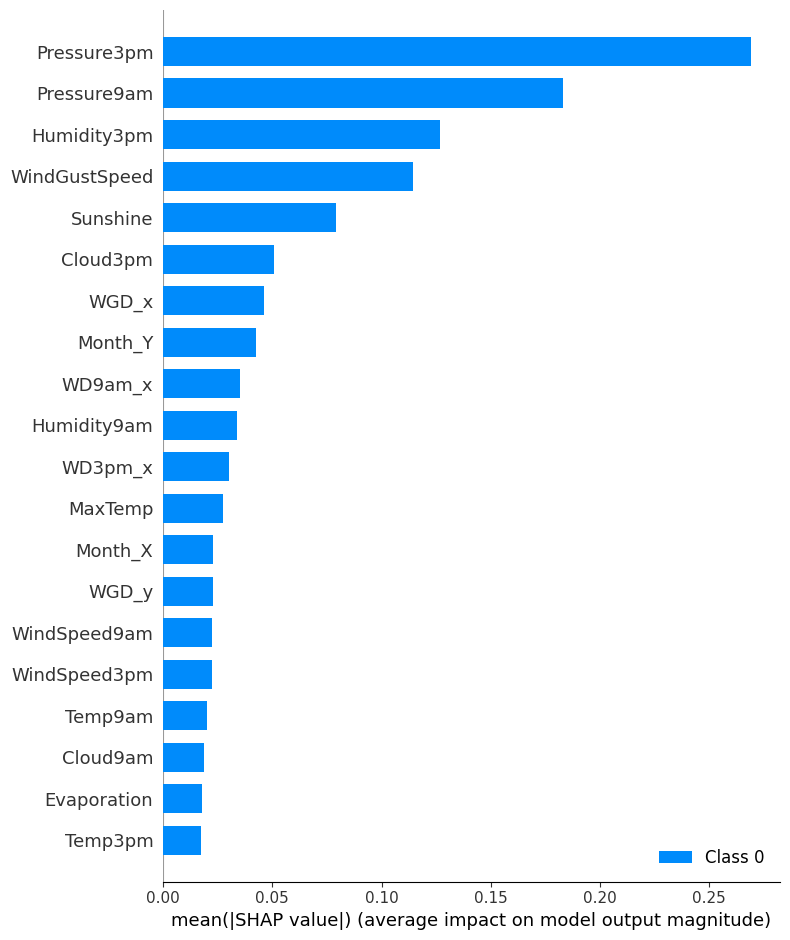

In [61]:
shap.summary_plot(shap_values,X_test_cla_processed,feature_names=feature_names)

In [62]:
index = 0
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)


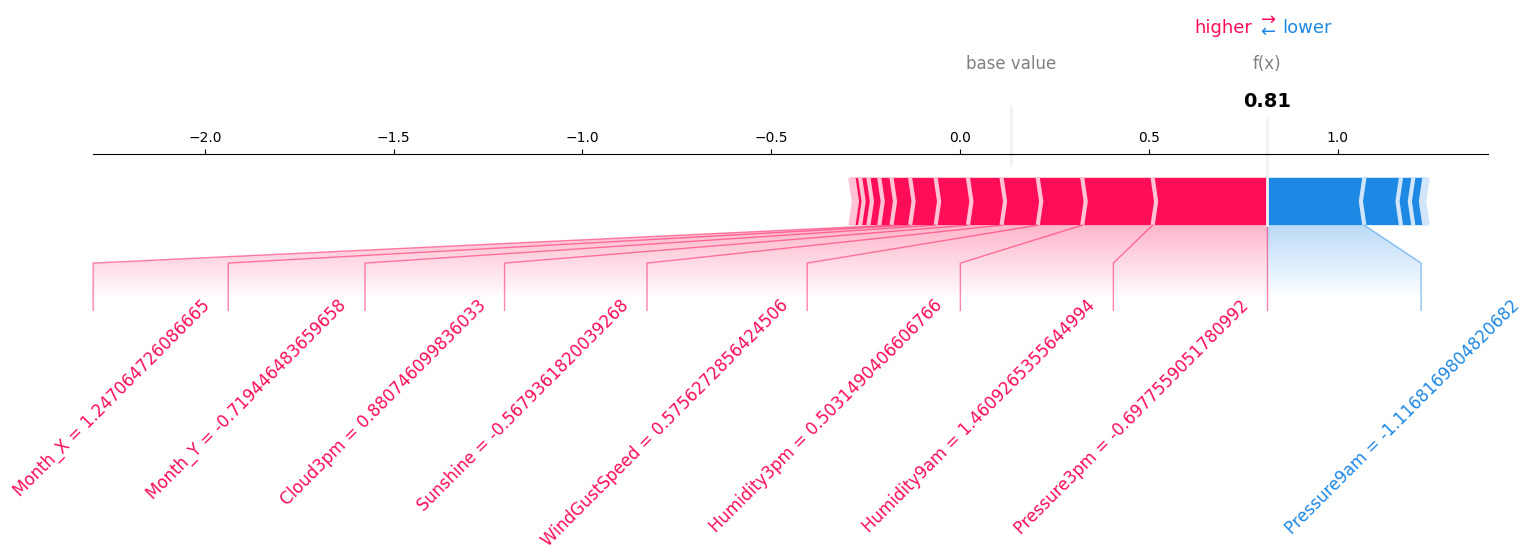

In [64]:
shap.force_plot(explainer.expected_value, explanation.values[0, :], X_test_cla_processed[index, :], feature_names=feature_names, matplotlib=True, figsize=(18, 4), \
                text_rotation=45)

#Conclusiones

El objetivo principal de este trabajo era la creación de modelos que predijeran las variables RainTomorrow y RainfallTomorrow para luego ser puestos en producción.

Se realizó un análisis de los datos mediante distintas técnicas como una matriz de correlación, boxplots, ver que tan balanceado están los datos, etc.

Luego se trataron los datos faltantes y se crearon conjuntos de train y test antes de imputar y estandarizar, para luego utilizar estos conjuntos en los distintos modelos que se crearon.

En los modelos de clasificación fue necesario tener en cuenta el desbalanceo de los datos para utilizar métricas de desempeño pertinentes y técnicas de balanceo.

En las redes neuronales los hiperparámetros fueron optimizados con Optuna y se consiguieron modelos con un rendimiento aceptable.

Luego mediante la librería SHAP se hizo un análisis explicativo para entender como afecta cada variable en el modelo.

Finalmente se pusieron en producción los modelos de redes neuronales con la librería joblib